# Next Instruction Prediction Training


In [1]:
import torch

torch.cuda.is_available()
#!/usr/bin/env python3
from num2words import num2words
import sys,os
from elftools.elf.elffile import ELFFile
from elftools.elf.segments import Segment
from capstone import *
from capstone.x86 import *

import os,pickle,re
import json 

import sys,os
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


# DATASET GENERATION

# Creating the pipeline

In [2]:
from transformers import BertTokenizer, BertForNextSentencePrediction,BertForPreTraining
import torch
from transformers import PreTrainedTokenizerFast
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = PreTrainedTokenizerFast.from_pretrained("./../models/cusTokenizer_num_to_words")
print(tokenizer.pad_token) 
# model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')
MAX_TOKEN_LEN = 512
BATCH_SIZE = 256 +128


[PAD]


In [3]:

DATA_PATH = "/home/raisul/ANALYSED_DATA/mlm_x86_O2_d4_single_functions"

json_files = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) ]



def get_training_corpus():

    all = []

    for k, j_file in enumerate(json_files):
        if k>20000:
            break
        try:
            with open(j_file, 'r') as file:
                funct = file.read()
                funct = '\n'.join([line.split('|')[1] for line in funct.split('\n')[:-1]])    
                all.append(funct)
        except :
            pass
    # all.sort(key=len)
    return all
    
  

text = get_training_corpus()

# text = text[0:5000]
print("Functions Count: ",len(text), '\n')
example = text[10]


Functions Count:  20001 



In [4]:




#################################
def replace_num_with_word(input_string , replace_dict):
    def num_to_word(match):
        number = int( match.group(0))
        
        return num2words(replace_dict[number]).replace(' ','').replace('-',"")

    result_string = re.sub(r'\b\d+\b', num_to_word, input_string)
    
    return result_string


updated_text = []
print("Functions Count: ",len(text), '\n')

for program in text:

    numbers = [int(s) for s in re.findall(r'\b\d+\b', program)]
    numbers = sorted(set(numbers) , reverse=True)
    number_word_dict={}
    
    for ix,n in enumerate(numbers):
        number_word_dict[n] = len(numbers)-1 -ix
    program = replace_num_with_word(program , number_word_dict)


    updated_text.append(program)
# text = updated_text






# with open('number_cusToken.pickle', 'wb') as handle:
#     pickle.dump(text, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('number_cusToken.pickle', 'rb') as handle:
#     text = pickle.load(handle)



Functions Count:  20001 



In [5]:
# from statistics import mean
# org =  ([len(t) for t in text])
# numm =  ([len(t) for t in updated_text])
# max = 0
# idx = 0
# for i in range(len(org)):
#     dif = numm[i]-org[i]
#     if dif>max :
#         max = dif
#         idx = i
# # print(text[idx], '_____\n\n\n')
# print(updated_text[idx])
# print(max,idx)

In [6]:
# text[51].split(delim)

We'll assign a 50% probability of using the genuine next sentence, and 50% probability of using another random sentence.

To make this simpler, we'll create a *'bag'* of individual sentences to pull from when selecting a random sentence B.

In [7]:
delim = '\n'
bag = [instruction for instruction_cluster in text for instruction in instruction_cluster.split(delim)  if instruction!= '']
bag_size = len(bag)
print(bag_size)

1028376


And now we create our 50/50 NIP training data.

In [8]:
import random

history = []
next_instruction = []
label = []

page_len = 5
instruction_pages = []
for instruction_cluster in text:
    instructions = [
        instruction for instruction in instruction_cluster.split(delim) if instruction != ''
    ]
    if len(instructions)>page_len:
        
        for i in range(0,len(instructions),page_len):
            instruction_pages.append(instructions[i:i+page_len])
        
print(len(instruction_pages))
print(instruction_pages[0])

for instruction_page in instruction_pages:
    
#     instructions = [
#         instruction for instruction in instruction_page.split(';') if instruction != ''
#     ]
    
    
#     num_instructions = len(instruction_page)
    
    

#     start = random.randint(0, num_instructions-2)
    # 50/50 whether is IsNextSentence or NotNextSentence
    if random.random() >= 0.5:
        # this is IsNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(instruction_page[-1])
        label.append(0)
    else:
        index = random.randint(0, bag_size-1)
        # this is NotNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(bag[index])
        label.append(1)

213191
['ENDBR64', 'PUSH RBX', 'LEA RBX,[8616]', 'MOV RDI,RBX', 'SUB RSP,16']


In [9]:
print(len(label))
for i in range(3):
    print(label[i])
    print('->',history[i] , '\n')
    print('# ',next_instruction[i] , '\n')

213191
1
-> ENDBR64
PUSH RBX
LEA RBX,[8616]
MOV RDI,RBX 

#  POP RBX 

0
-> MOV RAX,qword ptr FS:[40]
MOV qword ptr [RSP + 8],RAX
XOR EAX,EAX
CALL 4320 

#  LEA RDI,[8256] 

0
-> CALL 4320
LEA RSI,[8283]
MOV EDI,2
XOR EAX,EAX 

#  CALL 4384 



Our data is now ready for tokenization, this time we truncate/pad each token to the same length of *512* tokens.

In [10]:
inputs = tokenizer(history, next_instruction, return_tensors='pt', 
                   max_length=MAX_TOKEN_LEN, truncation=True, padding=True)
ground_truth = inputs.copy() 

In [11]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

We can see that the *token_type_ids* tensors have been built correctly (eg **1** indicating sentence B tokens) by checking the first instance of *token_type_ids*:

In [12]:
print(inputs.input_ids.shape)
inputs.token_type_ids[0]

torch.Size([213191, 95])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The **0** tokens following our sentence B tokens correspond to *PAD* tokens.

Alongside this, we need to create a *labels* tensor too - which corresponds to the values contained within our `label` variable. Our *labels* tensor must be a *LongTensor*, and we will need to transpose the tensor so that it matches our other tensors' dimensionality.

In [13]:
inputs['next_sentence_label'] = torch.LongTensor([label]).T


And the labels tensor is simply a clone of the input_ids tensor before masking.

In [14]:
inputs['labels'] = inputs.input_ids.detach().clone()

In [15]:
inputs.input_ids[-1]

tensor([  2,   3, 109,  14,  74,  78,  83,   3,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])

Now we mask tokens in the input_ids tensor using the 15% probability for MLM - ensuring we don't mask CLS, SEP, or PAD tokens.

In [16]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [17]:
mask_arr.shape
# inputs.input_ids.shape[0]

torch.Size([213191, 95])

And now take the indices of each True value within each vector.

In [18]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [19]:
len (selection) , len(inputs.input_ids), selection[0:3]

(213191,
 213191,
 [[4,
   8,
   13,
   21,
   26,
   36,
   39,
   40,
   44,
   53,
   54,
   55,
   56,
   61,
   66,
   67,
   72,
   80,
   81,
   84,
   91],
  [7, 16, 20, 22, 48, 57, 58, 71, 72, 80, 84],
  [3, 6, 19, 25, 31, 32, 35, 45, 56, 64, 74, 83]])

Then apply these indices to each row in input_ids, assigning each value at these indices a value of 103.

In [20]:
inputs.input_ids[0][selection[0]]

tensor([113,  64, 117,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1])

In [21]:
masked_labels = []
for i in range(inputs.input_ids.shape[0]):
    masked_labels.append(inputs.input_ids[i, selection[i]])
    inputs.input_ids[i, selection[i]] = 103
# masked_labels[0]
inputs["mask_arr"] = mask_arr

In [22]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels', 'mask_arr'])

The `inputs` tensors are now ready, and we can begin building the model input pipeline for training. We first create a PyTorch dataset from our data.

In [23]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

Initialize our data using the `MeditationDataset` class.

In [24]:
dataset = MeditationsDataset(inputs)

In [25]:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset  = torch.utils.data.Subset(dataset, range(train_size))
validation_dataset = torch.utils.data.Subset(dataset, range(train_size , len(dataset)))

train_size, len(train_dataset) , len(validation_dataset)

(170552, 170552, 42639)

And initialize the dataloader, which we'll be using to load our data into the model during training.

In [26]:

train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True )

In [27]:
# 

Now we can move onto setting up the training loop. First we setup GPU/CPU usage.

In [28]:

# and move our model over to the selected device
model.to(device)

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Activate the training mode of our model, and initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).

In [29]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np


Now we can move onto the training loop, we'll train for a couple of epochs (change `epochs` to modify this).

In [30]:
# odict_keys(['loss', 'prediction_logits', 'seq_relationship_logits'])

In [31]:

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(training_data, validation_data , label ):

    font_size = 10
    x_labels = [ i for i in range(len(training_data)) ]

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, training_data , 'r') 
    plt.plot(x_labels, validation_data , 'b') 
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend(['Training', 'Validation'], loc='upper left') 
    
    plt.savefig('./../results/'+label+'.pdf')
    plt.show()



/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████| 445/445 [09:06<00:00,  1.23s/it, loss=2.65]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.527894534664269   Masked Token f1 0.5501314327899052     SEQ F1 0.5509277448198694


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.19it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.18044104303917313    v_masked_token_ F1:  0.5624633049391766  V SEQ F1:  0.5632580674137136


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


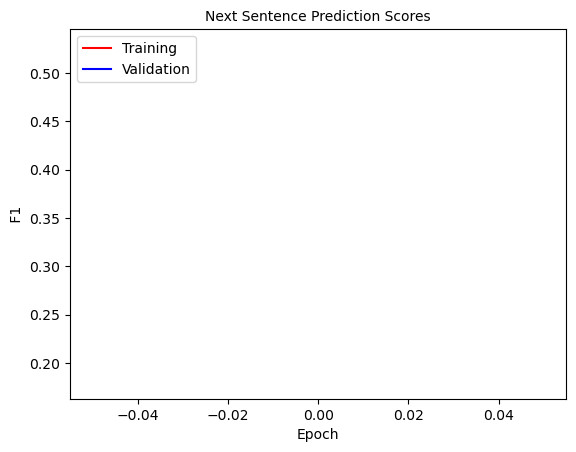

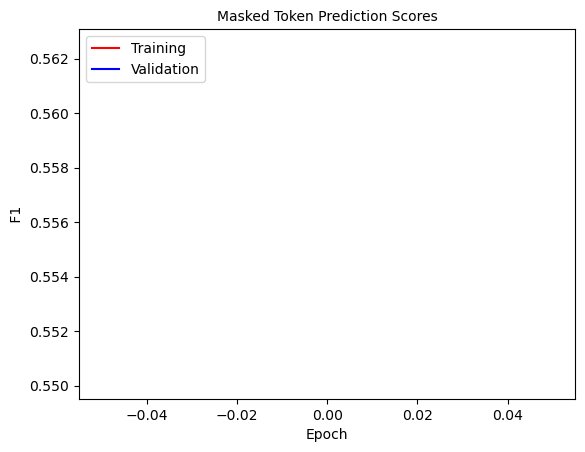

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 445/445 [09:09<00:00,  1.23s/it, loss=2.01]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5244954477989638   Masked Token f1 0.5629236306352886     SEQ F1 0.5701434316738997


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.6182261170275475    v_masked_token_ F1:  0.5632433541279562  V SEQ F1:  0.6590659595767541


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


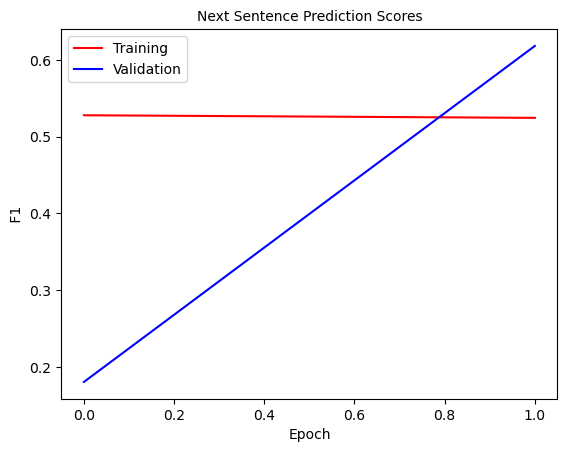

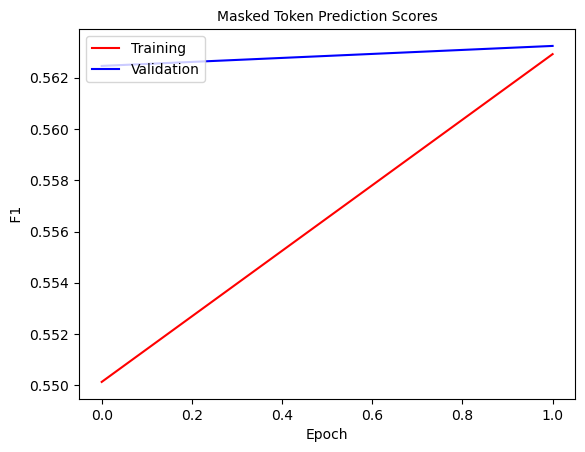

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 445/445 [09:06<00:00,  1.23s/it, loss=1.83]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5449357734294307   Masked Token f1 0.6527994922730692     SEQ F1 0.6841717892385102


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.19it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.6756393437312732    v_masked_token_ F1:  0.6909524061109779  V SEQ F1:  0.6949808166575381


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


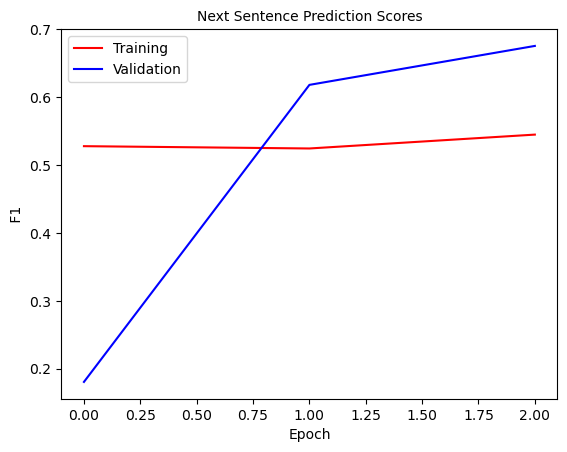

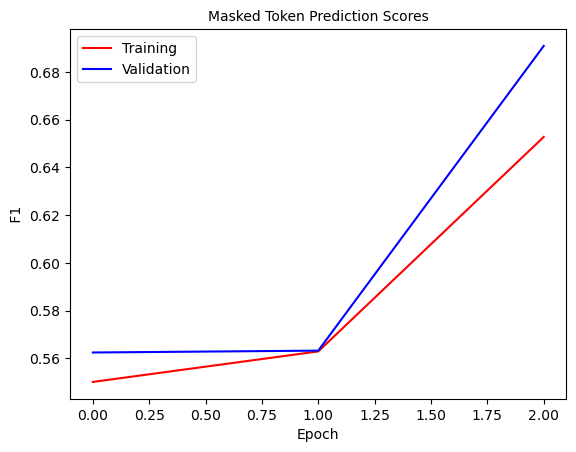

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=1.8] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5531408262994225   Masked Token f1 0.7028058678900863     SEQ F1 0.7123524617144562


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.3934125057410931    v_masked_token_ F1:  0.7191083443527523  V SEQ F1:  0.7300585752035204


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


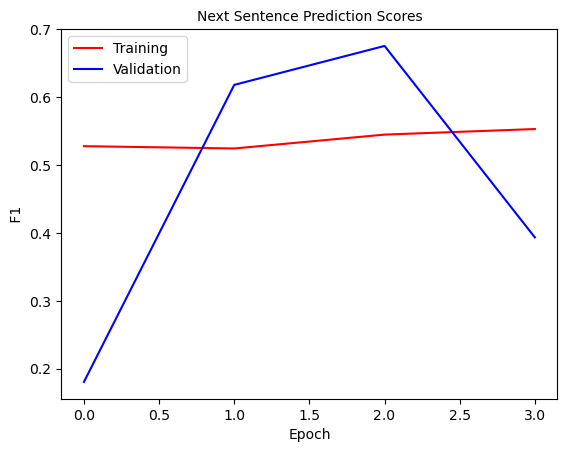

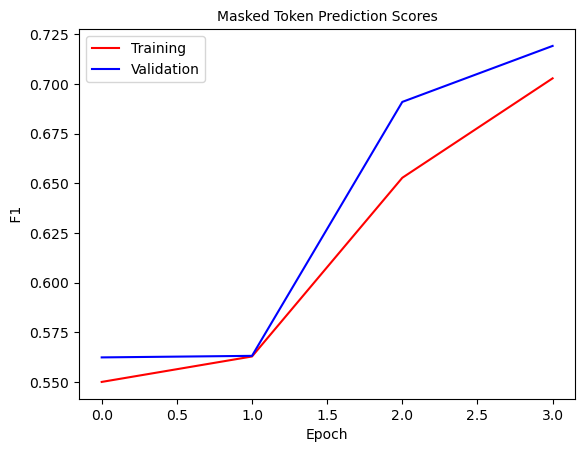

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 4: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=1.4] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

Training:   Instruction f1:  0.5592455471440939   Masked Token f1 0.7196510925000825     SEQ F1 0.7631972268797567


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.4692761459997542    v_masked_token_ F1:  0.7363634195184655  V SEQ F1:  0.8587999339998221


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


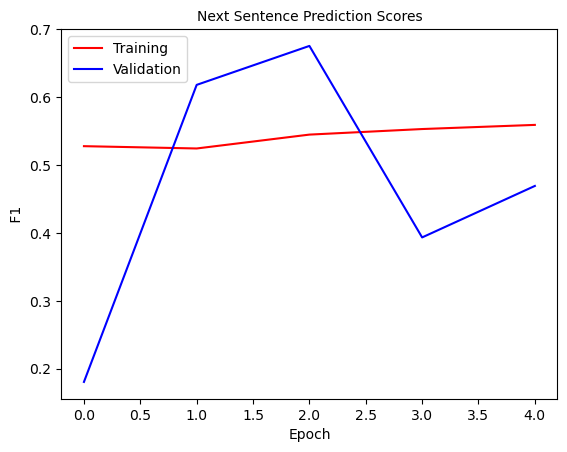

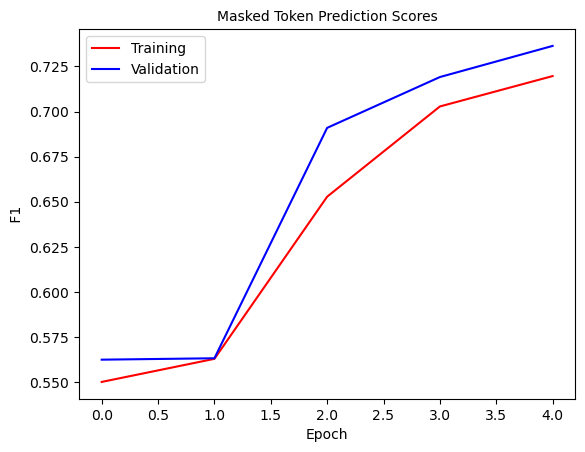

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 5: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.942]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.5892366763174571   Masked Token f1 0.7381021383799908     SEQ F1 0.9082682525289099


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.6733445616523358    v_masked_token_ F1:  0.7612938884033804  V SEQ F1:  0.9498433291228403


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


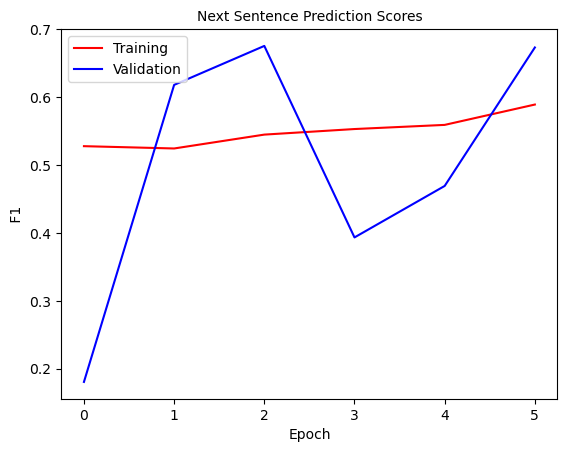

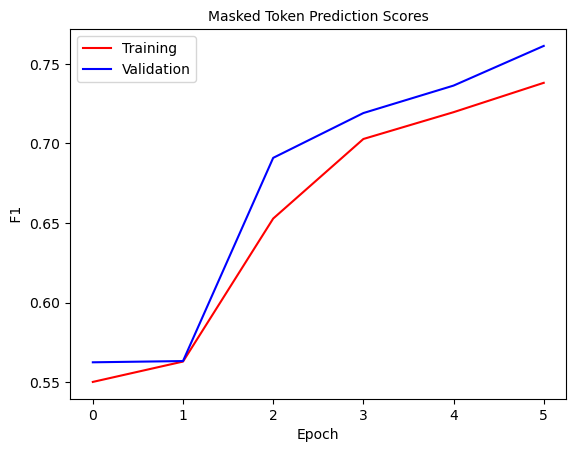

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 6: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.777]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.6372716353751817   Masked Token f1 0.7603086525690372     SEQ F1 0.9495123257390952


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.7051970921569513    v_masked_token_ F1:  0.786431921666242  V SEQ F1:  0.959217016687225


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


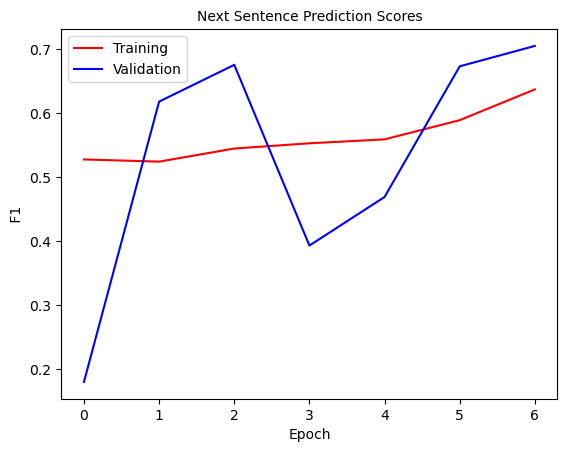

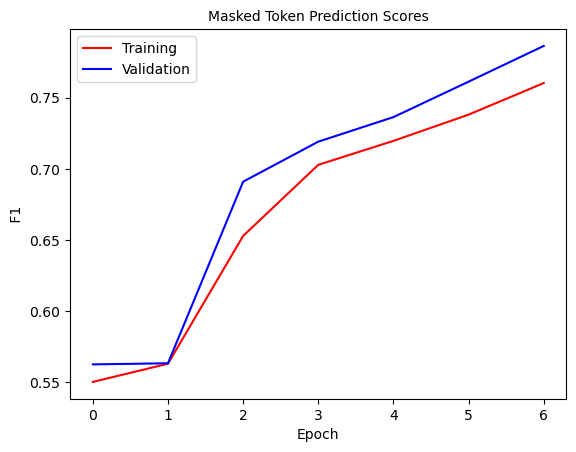

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 7: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.747]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.6749198252569379   Masked Token f1 0.7819071661731365     SEQ F1 0.9583444011980685


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.6999360204734485    v_masked_token_ F1:  0.8029116636675957  V SEQ F1:  0.9653296003383126


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


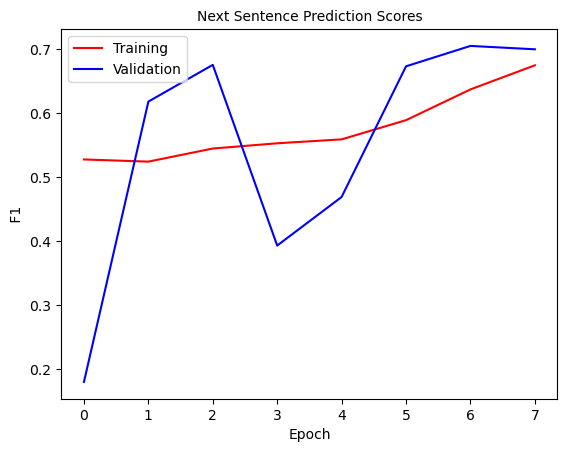

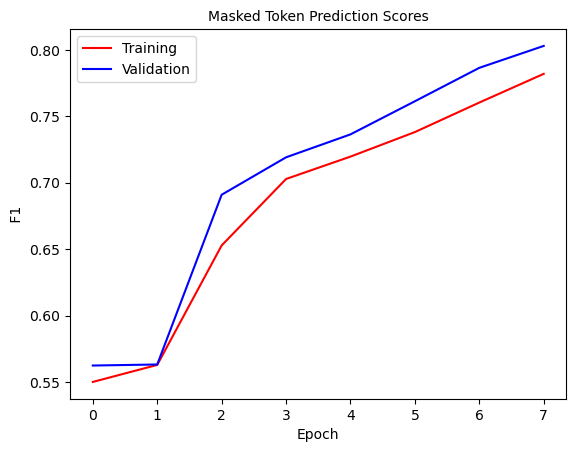

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 8: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.663]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.7046060955291936   Masked Token f1 0.7982647860667988     SEQ F1 0.9637871173381205


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7410341141024395    v_masked_token_ F1:  0.8148356872062071  V SEQ F1:  0.9688323065613591


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


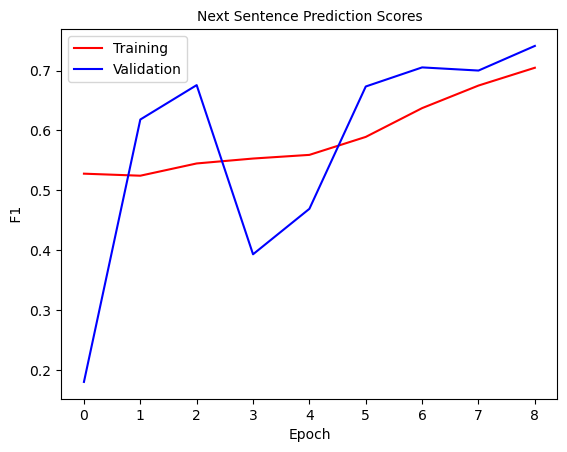

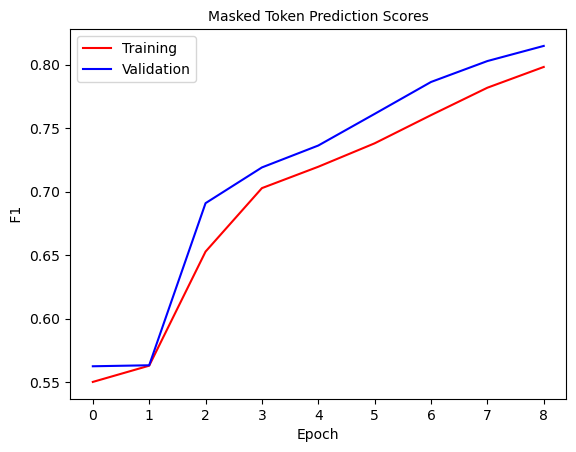

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 9: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.73] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Training:   Instruction f1:  0.7275621570060578   Masked Token f1 0.8099805804928115     SEQ F1 0.9672463684421522


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.7612410817985731    v_masked_token_ F1:  0.8251856645647901  V SEQ F1:  0.9711085278160729


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


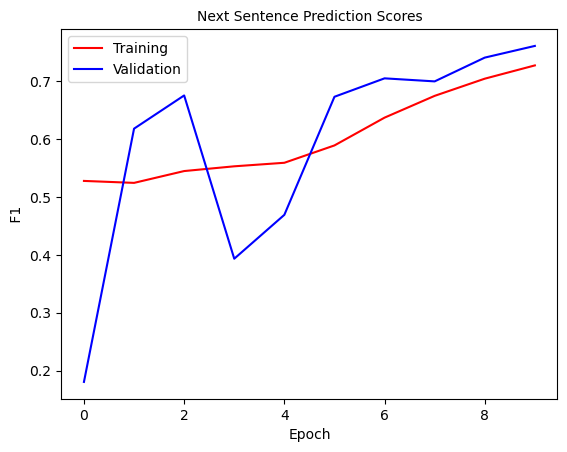

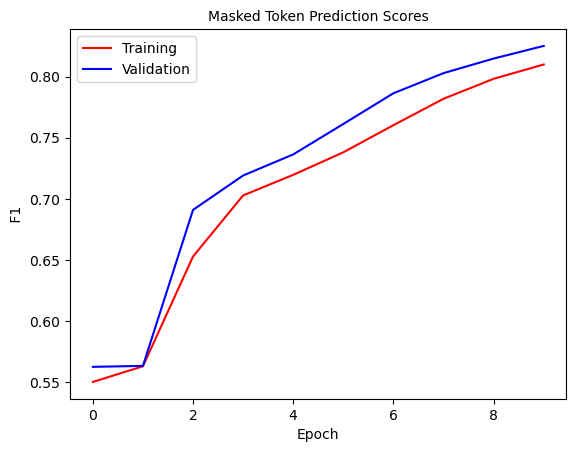

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 10: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.633]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7479147472513973   Masked Token f1 0.818846735894338     SEQ F1 0.9695436264211732


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.7765506735849955    v_masked_token_ F1:  0.8320544782946943  V SEQ F1:  0.9728828100270284


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


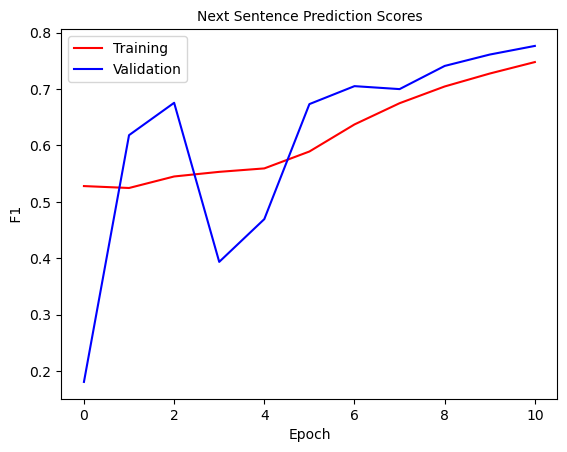

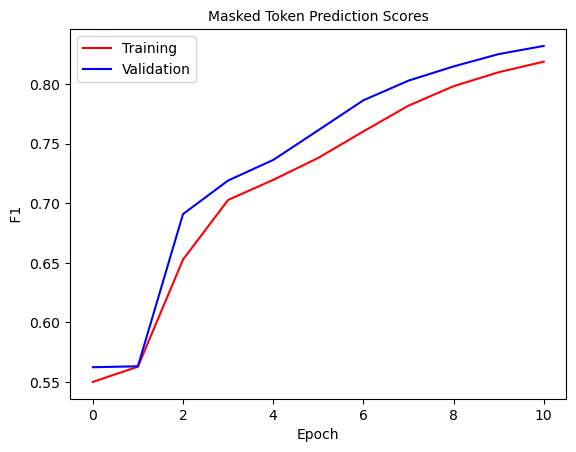

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 11: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.522]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7642690766227369   Masked Token f1 0.826201597096035     SEQ F1 0.9712953245665508


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.7873341488660958    v_masked_token_ F1:  0.8396110907694124  V SEQ F1:  0.9742747755292999


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


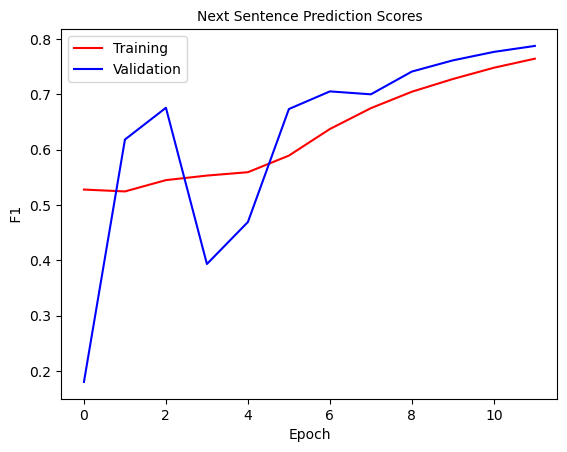

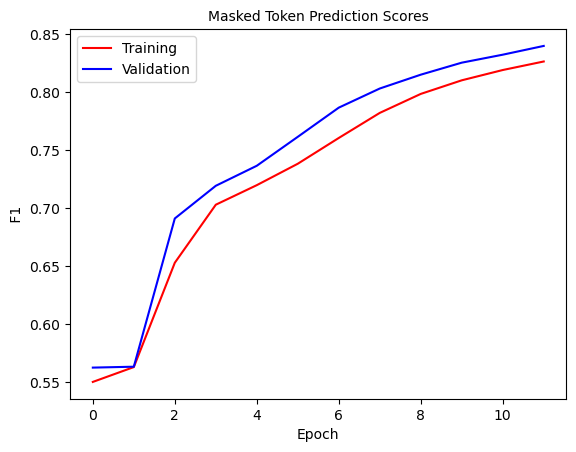

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 12: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.486]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7778437454563079   Masked Token f1 0.8326404014288257     SEQ F1 0.972736636086815


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.796365529317117    v_masked_token_ F1:  0.8449737350212749  V SEQ F1:  0.9755376077365074


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


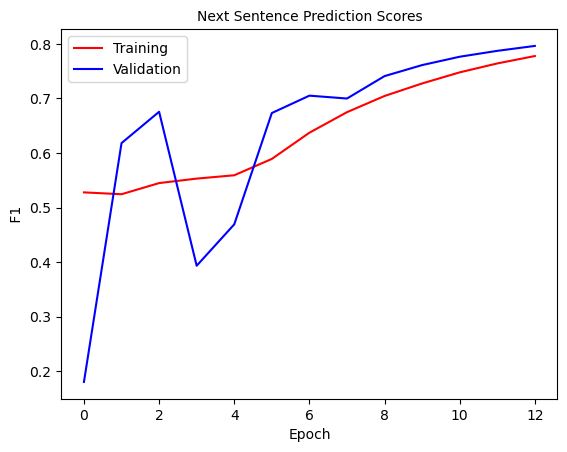

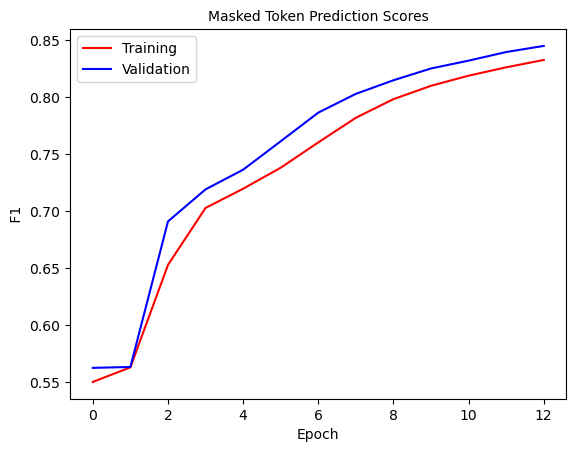

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 13: 100%|██████████| 445/445 [09:09<00:00,  1.23s/it, loss=0.522]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7876531870150588   Masked Token f1 0.8383974850661524     SEQ F1 0.9738850774889188


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8050346896681042    v_masked_token_ F1:  0.851371340358111  V SEQ F1:  0.9765577064977934


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


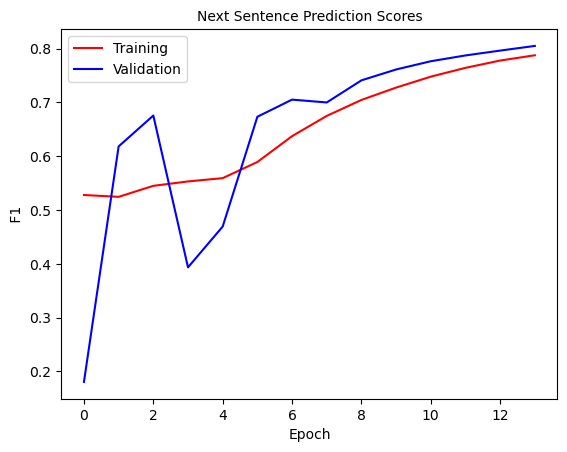

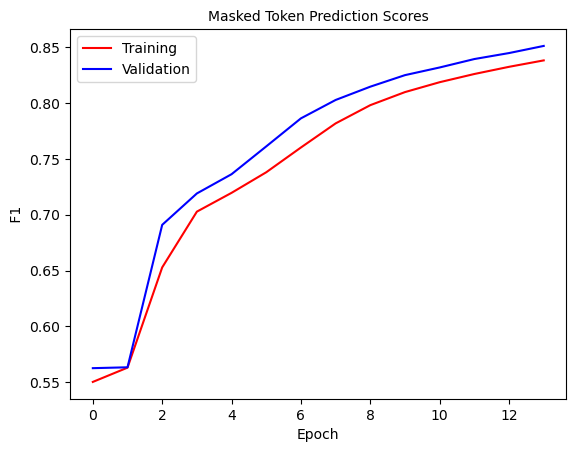

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 14: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.521]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.7965004100139887   Masked Token f1 0.8433193633437557     SEQ F1 0.9748560869179304


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8044569843622974    v_masked_token_ F1:  0.8553747377567822  V SEQ F1:  0.9772131173783115


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


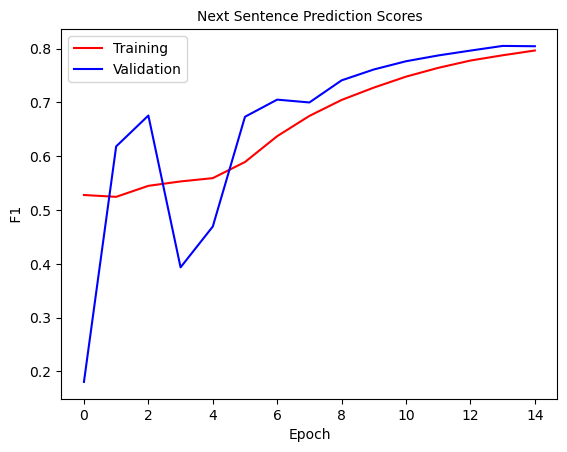

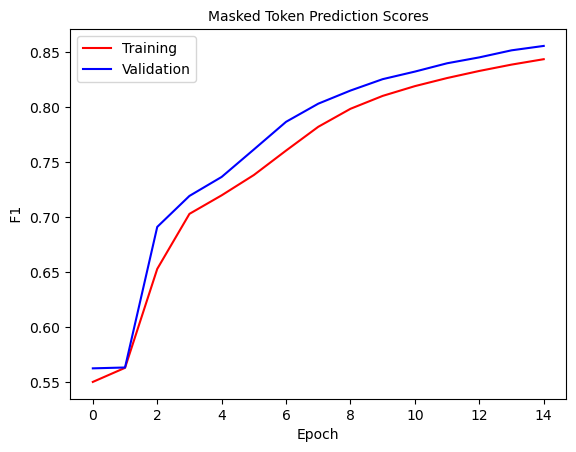

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 15: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.478]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8033456689833619   Masked Token f1 0.8477753317326353     SEQ F1 0.9756700661461614


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8137759297108088    v_masked_token_ F1:  0.859565177316843  V SEQ F1:  0.978017802945923


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


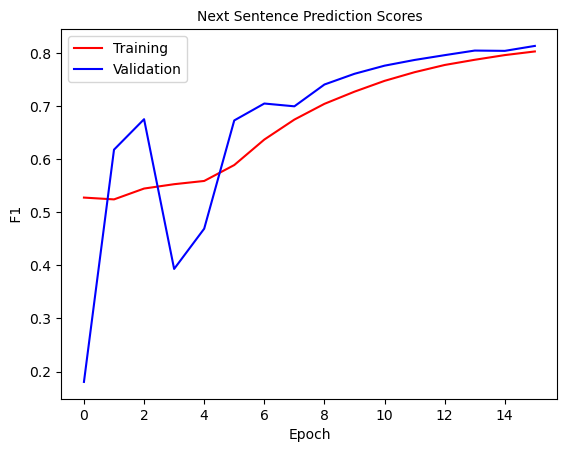

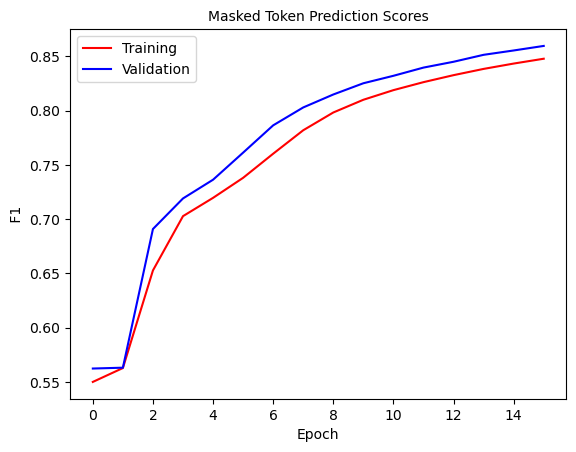

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 16: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.578]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8097196666305877   Masked Token f1 0.8519937870111556     SEQ F1 0.9764058959852663


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.809380725540491    v_masked_token_ F1:  0.8628704529567234  V SEQ F1:  0.978539481129538


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


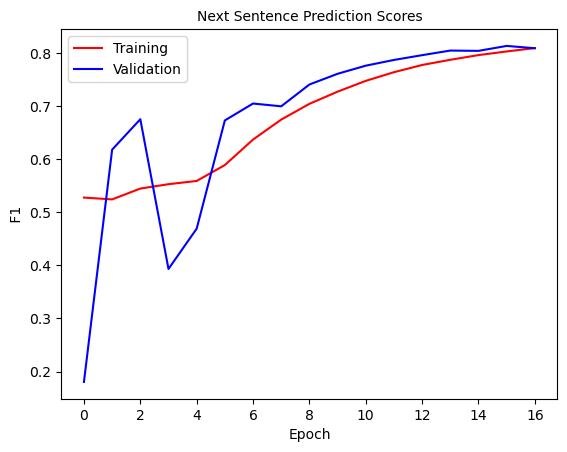

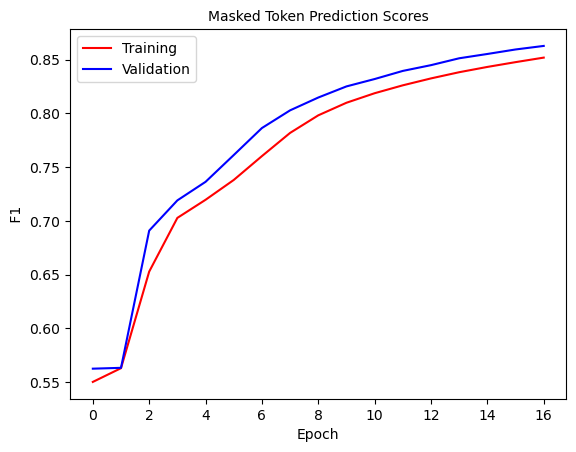

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 17: 100%|██████████| 445/445 [09:07<00:00,  1.23s/it, loss=0.576]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8154057175859082   Masked Token f1 0.8554742753310012     SEQ F1 0.9770391261754748


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8151912276009629    v_masked_token_ F1:  0.8661859260650487  V SEQ F1:  0.9791864962449621


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


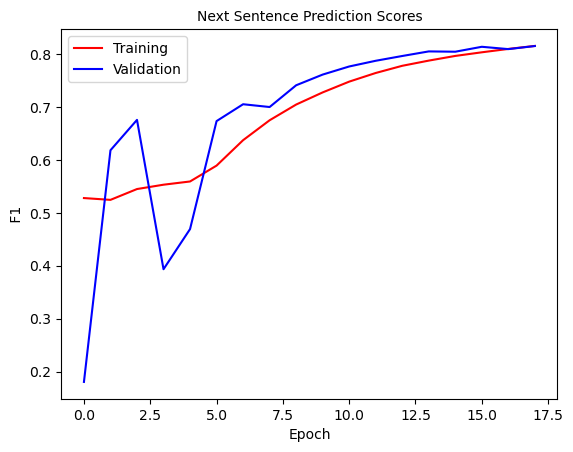

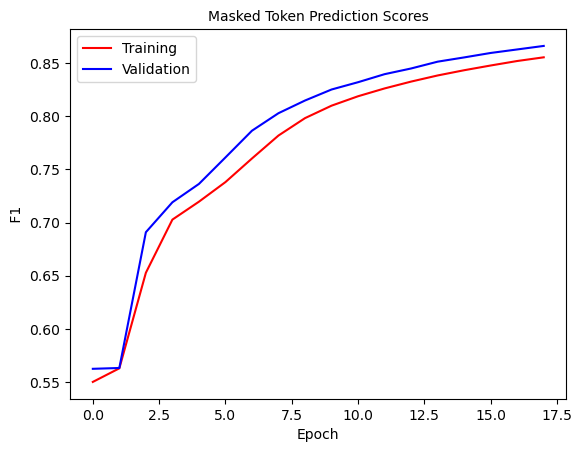

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 18: 100%|██████████| 445/445 [09:06<00:00,  1.23s/it, loss=0.365]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8210827822340432   Masked Token f1 0.8585718368272011     SEQ F1 0.9776156417691436


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8230199484133557    v_masked_token_ F1:  0.8694841830544764  V SEQ F1:  0.979662801545841


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


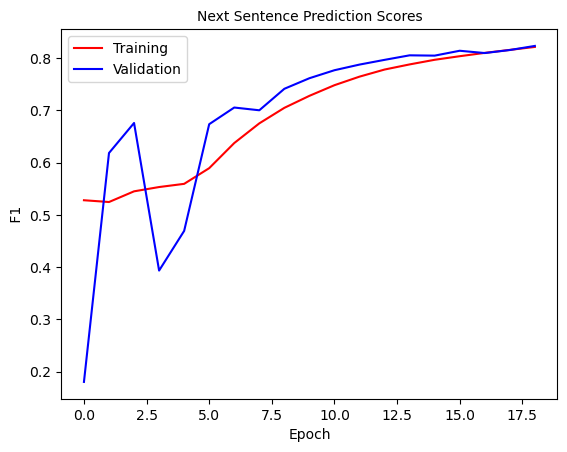

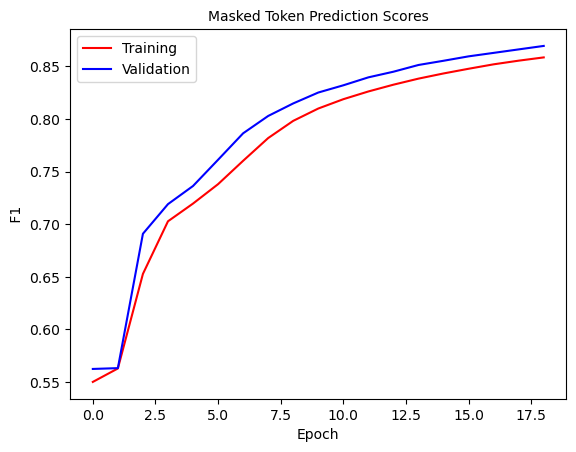

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 19: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.447]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8263527825919507   Masked Token f1 0.8613361991176637     SEQ F1 0.9781480433175819


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8241397363285898    v_masked_token_ F1:  0.8709225520136596  V SEQ F1:  0.9800278931995648


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


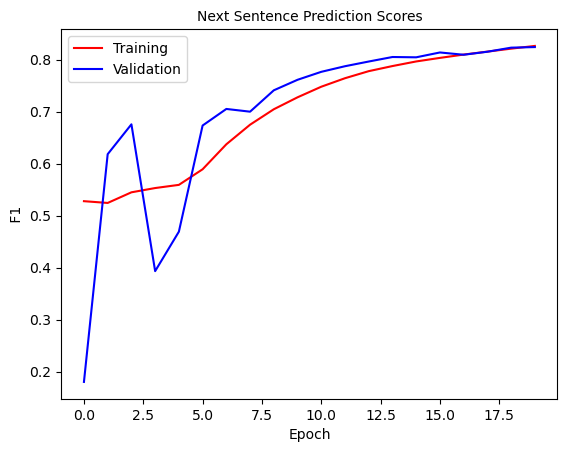

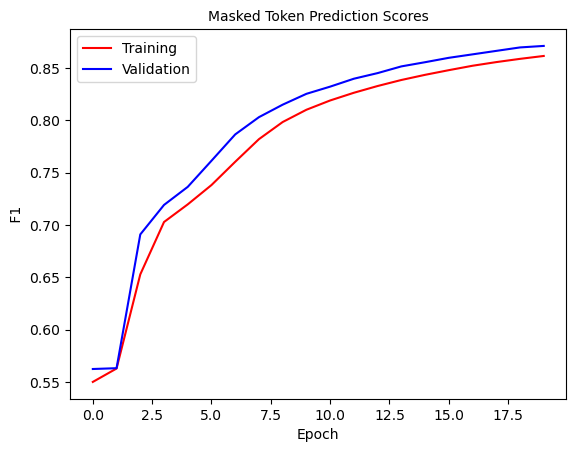

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 20: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.429]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8294507000763501   Masked Token f1 0.8636424615989104     SEQ F1 0.9785755690907443


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8272525796535043    v_masked_token_ F1:  0.8738986749403146  V SEQ F1:  0.9804688724955365


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


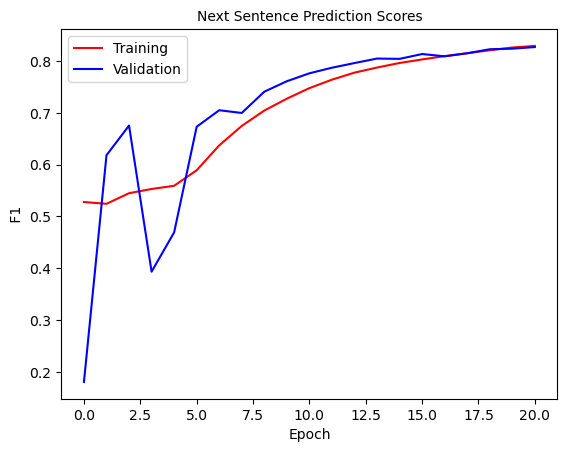

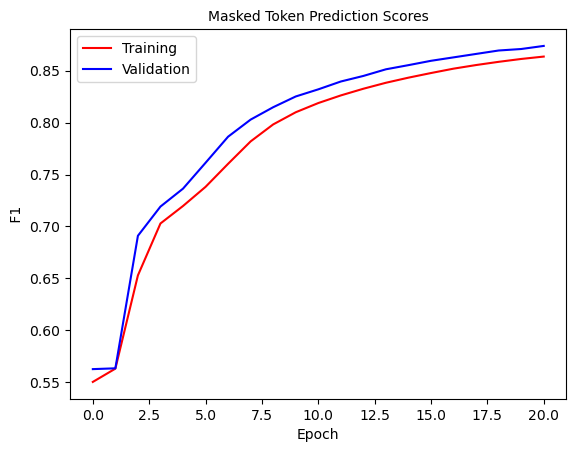

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 21: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.423]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8344640352514131   Masked Token f1 0.8661196962867085     SEQ F1 0.9789921356417757


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8301227573182247    v_masked_token_ F1:  0.8749822618300621  V SEQ F1:  0.9807004248019789


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


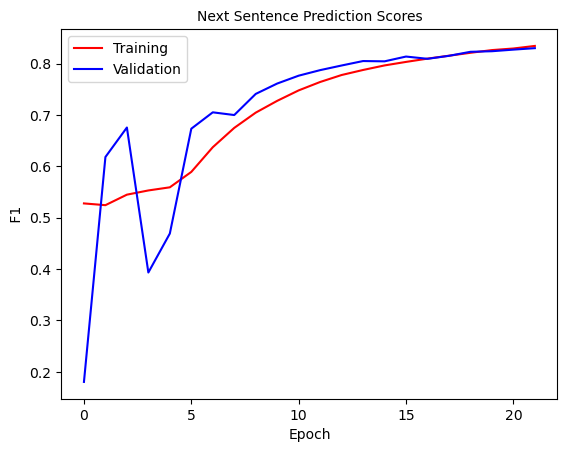

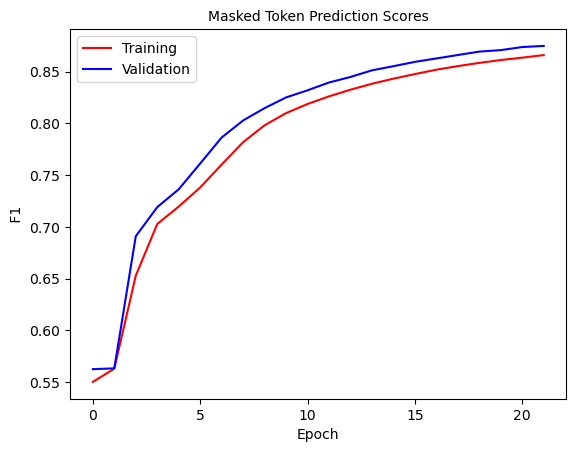

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 22: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.442]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8389591489412882   Masked Token f1 0.8679767987092994     SEQ F1 0.9793574927406206


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8320079996190658    v_masked_token_ F1:  0.8774227777500301  V SEQ F1:  0.981099873720344


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


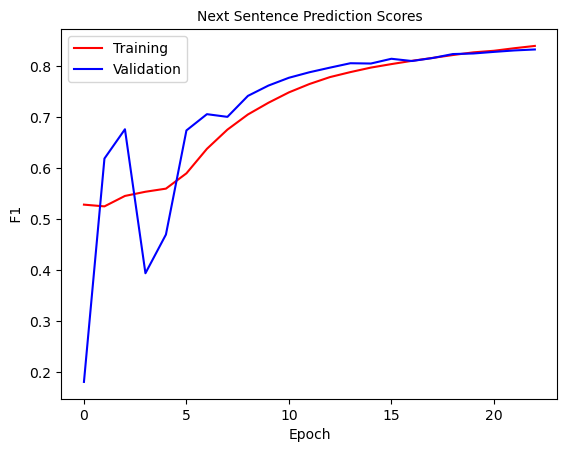

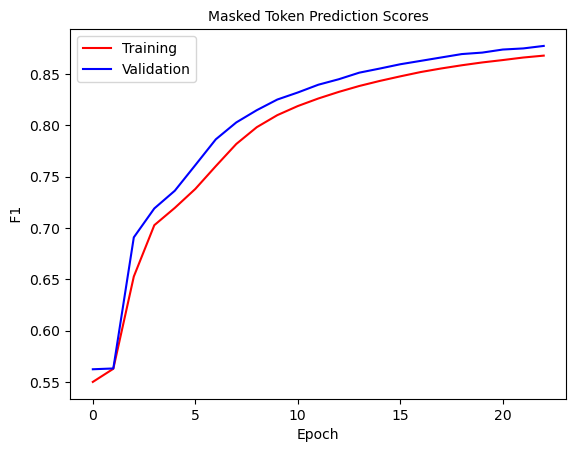

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 23: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.475]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8424964280139757   Masked Token f1 0.8701041185592463     SEQ F1 0.9797693773098646


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8336132863327734    v_masked_token_ F1:  0.8786116966870128  V SEQ F1:  0.9814510330207298


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


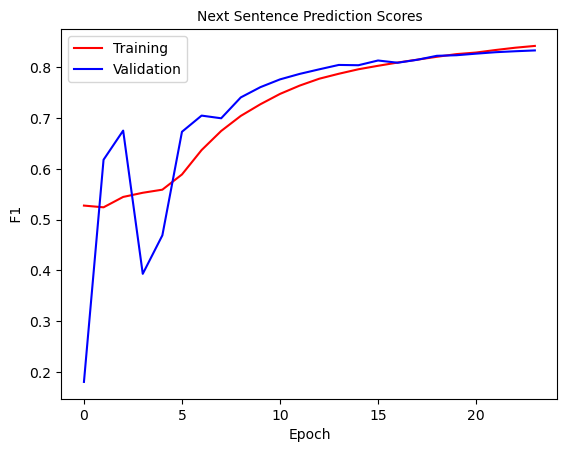

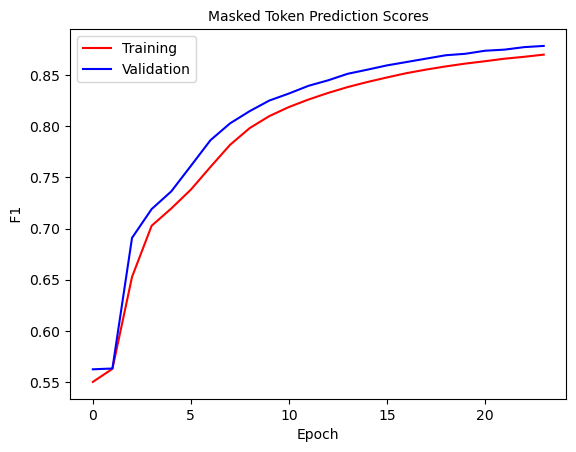

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 24: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.335]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8460442724141869   Masked Token f1 0.8714485052287492     SEQ F1 0.9800706991994779


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.834827388899485    v_masked_token_ F1:  0.879795509662317  V SEQ F1:  0.9818067662613221


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


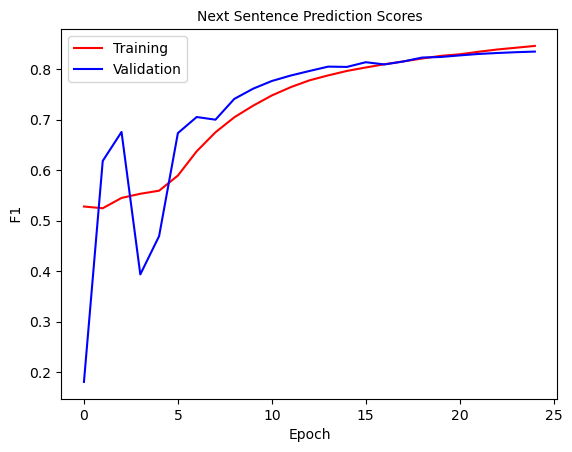

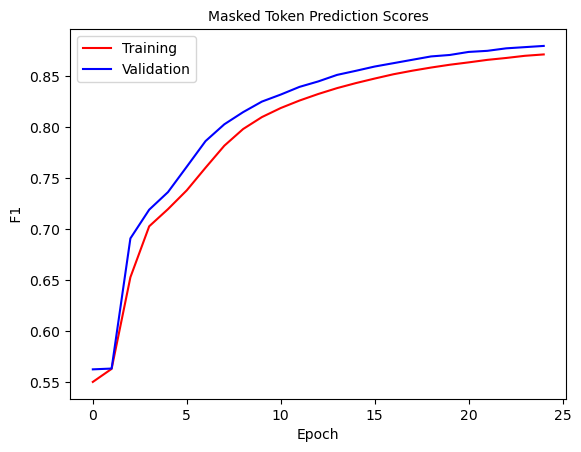

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 25: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.439]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8497183835153672   Masked Token f1 0.873228886130558     SEQ F1 0.9804382349123821


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8325872442839952    v_masked_token_ F1:  0.8815907764668621  V SEQ F1:  0.9820792608814046


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


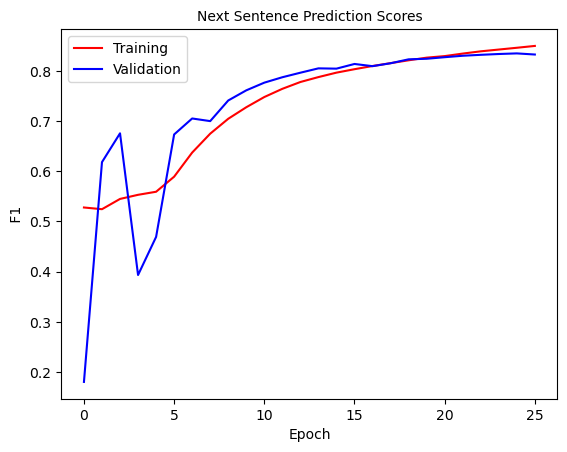

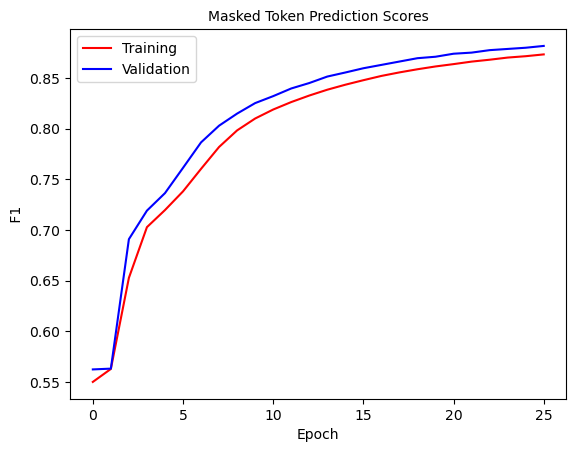

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 26: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.336]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8521284271284272   Masked Token f1 0.874219905882849     SEQ F1 0.980698017976066


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8362959604877002    v_masked_token_ F1:  0.8826886687359365  V SEQ F1:  0.9823289376524069


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


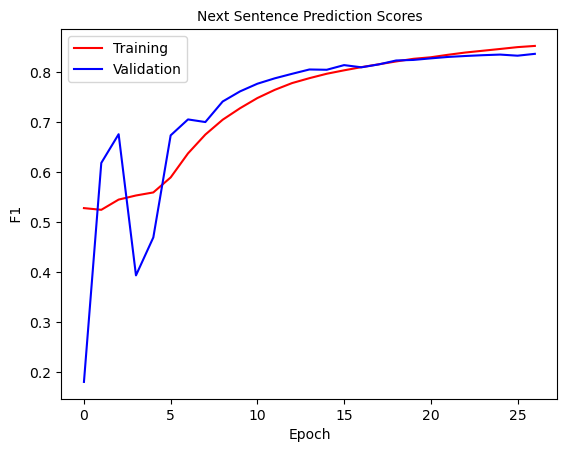

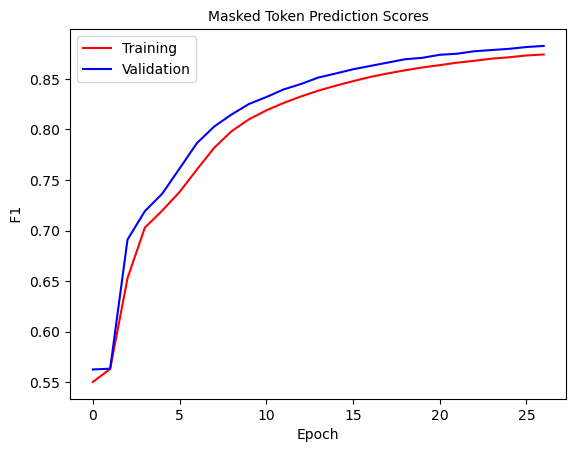

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 27: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.328]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8564028915315142   Masked Token f1 0.8756011234401848     SEQ F1 0.9809873312007709


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8399764289923394    v_masked_token_ F1:  0.8835644173987661  V SEQ F1:  0.9825685164015425


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


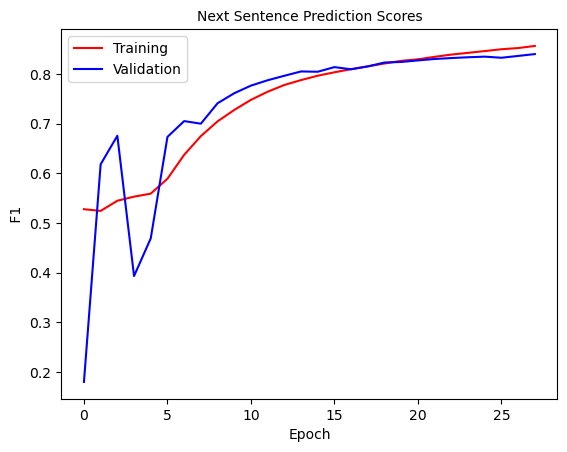

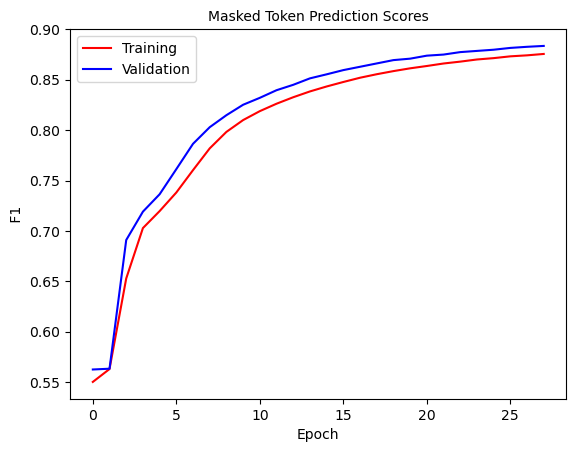

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 28: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.311]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8594767900001805   Masked Token f1 0.8767225985839778     SEQ F1 0.9812328151831021


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8378242195935408    v_masked_token_ F1:  0.8844629086352606  V SEQ F1:  0.9827014880831091


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


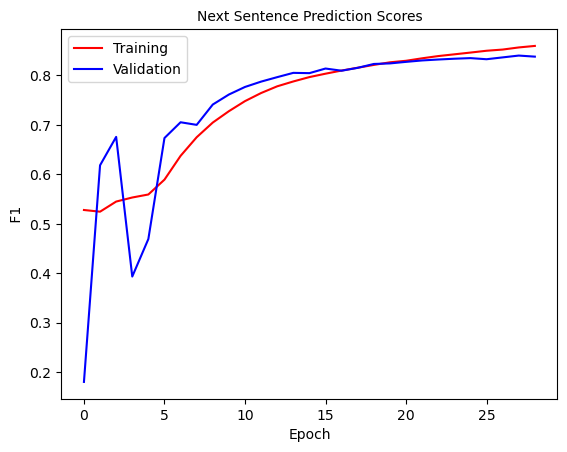

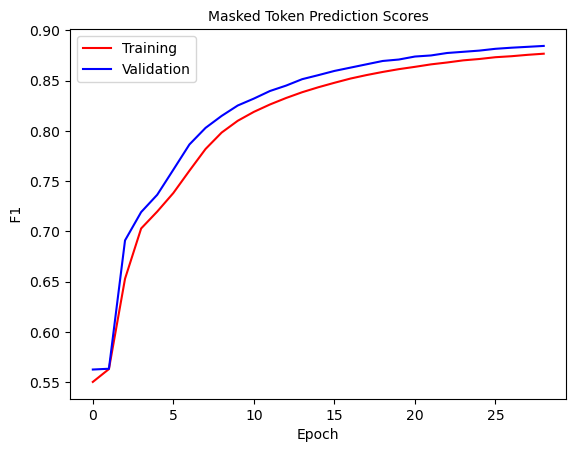

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 29: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.272]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8626380891704432   Masked Token f1 0.8779351849994673     SEQ F1 0.9814897906988225


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8395250131145977    v_masked_token_ F1:  0.8860436128995518  V SEQ F1:  0.9829530031199645


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


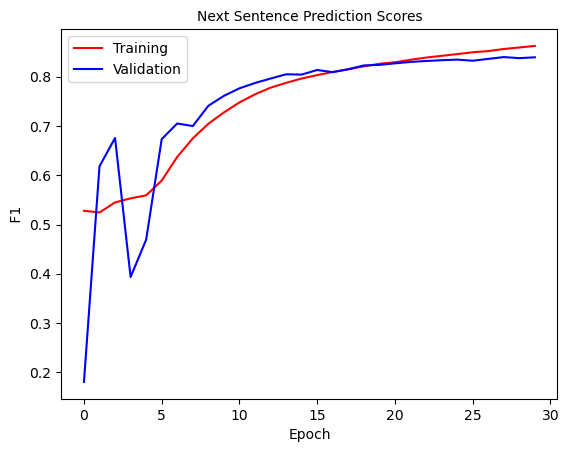

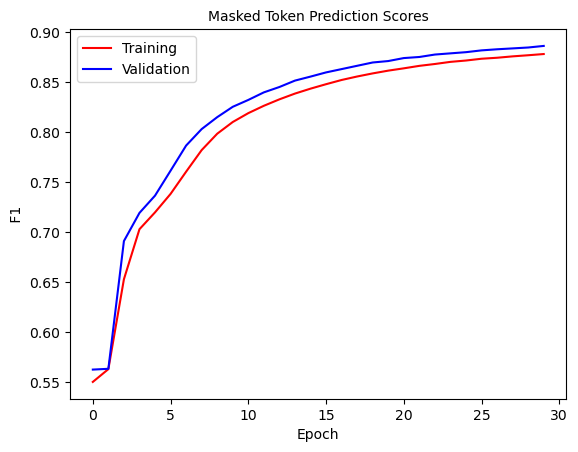

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 30: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.343]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8645351283129996   Masked Token f1 0.8788345700947346     SEQ F1 0.9816580948750201


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8433349034385303    v_masked_token_ F1:  0.8863264066914646  V SEQ F1:  0.983099907737925


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


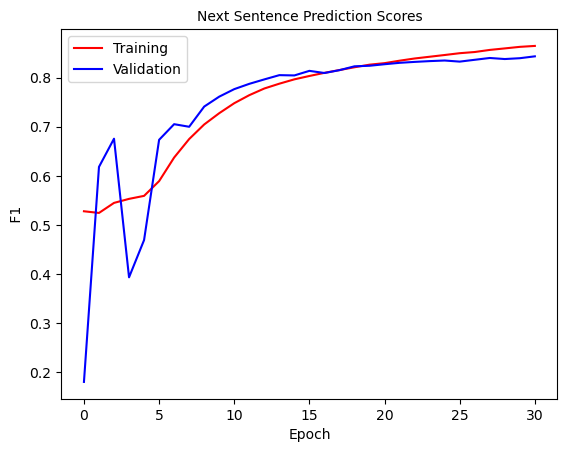

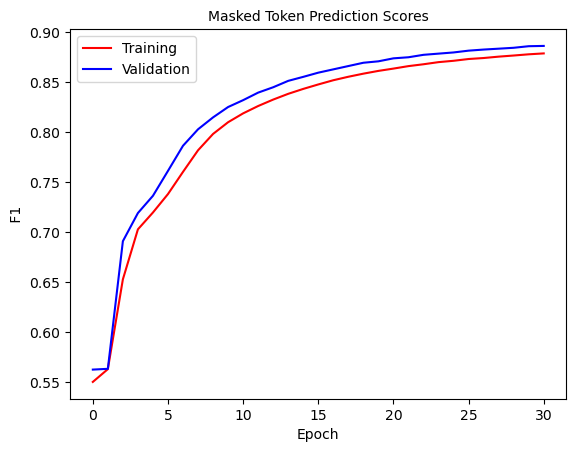

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 31: 100%|██████████| 445/445 [09:09<00:00,  1.23s/it, loss=0.349]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8676919380031238   Masked Token f1 0.8796783349508813     SEQ F1 0.981838327763258


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8414759057668946    v_masked_token_ F1:  0.8871395571399522  V SEQ F1:  0.9831703973042626


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


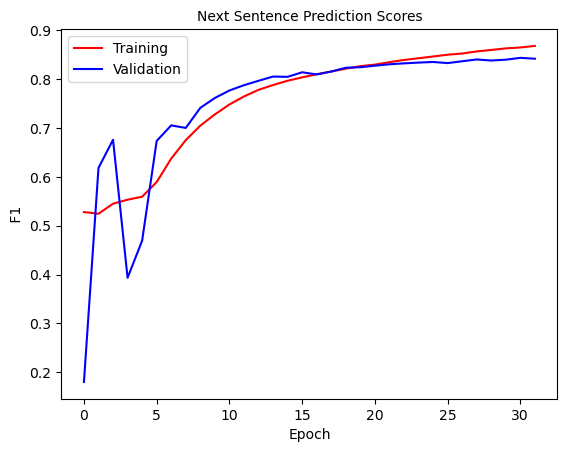

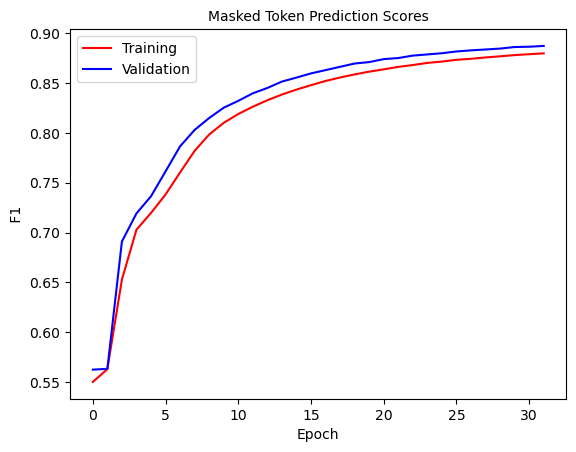

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 32: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.351]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8716137904528558   Masked Token f1 0.8805946770212998     SEQ F1 0.9820210813727623


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8432494279176201    v_masked_token_ F1:  0.8879903282164966  V SEQ F1:  0.9833120623261493


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


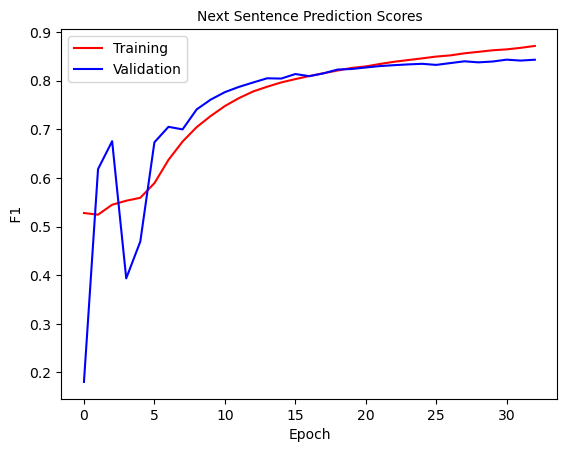

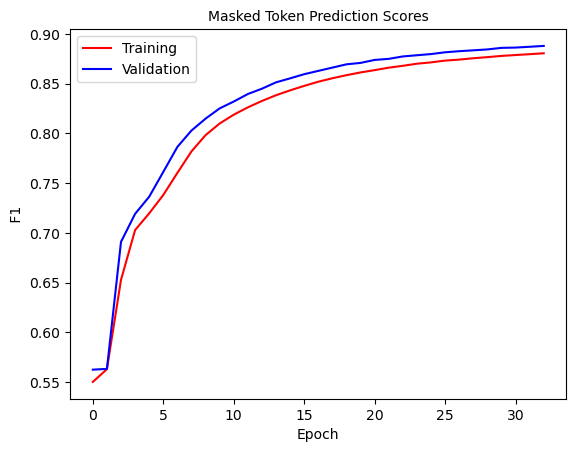

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 33: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.521]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8747456192482936   Masked Token f1 0.881531470221309     SEQ F1 0.9822137180404282


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8433139189349815    v_masked_token_ F1:  0.8884389479828668  V SEQ F1:  0.9834363346976958


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


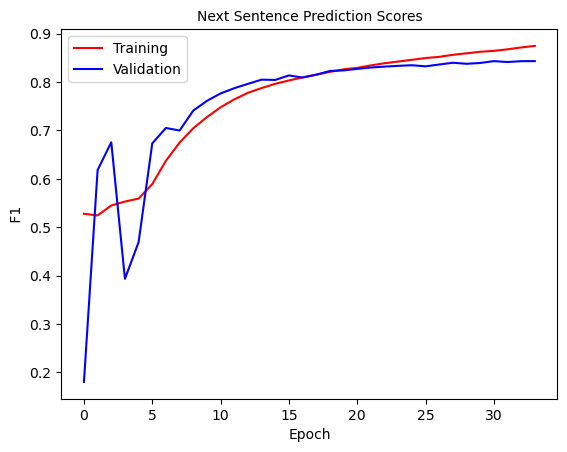

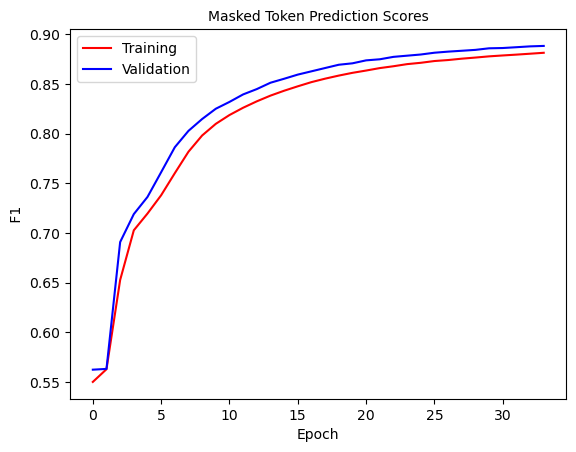

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 34: 100%|██████████| 445/445 [09:07<00:00,  1.23s/it, loss=0.352]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8774209821455382   Masked Token f1 0.8823180548883691     SEQ F1 0.9823451051989721


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8397463820725037    v_masked_token_ F1:  0.8891251693506687  V SEQ F1:  0.9835200315456882


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


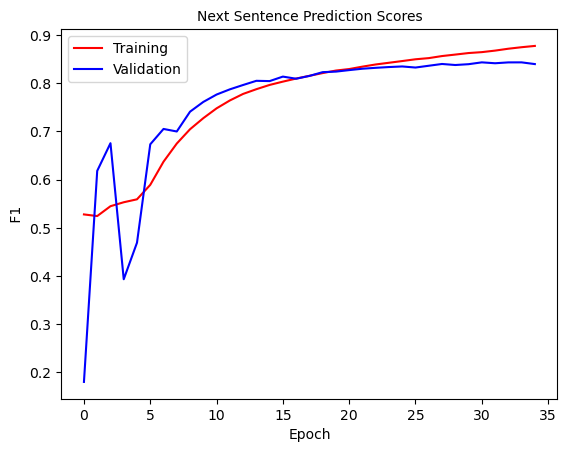

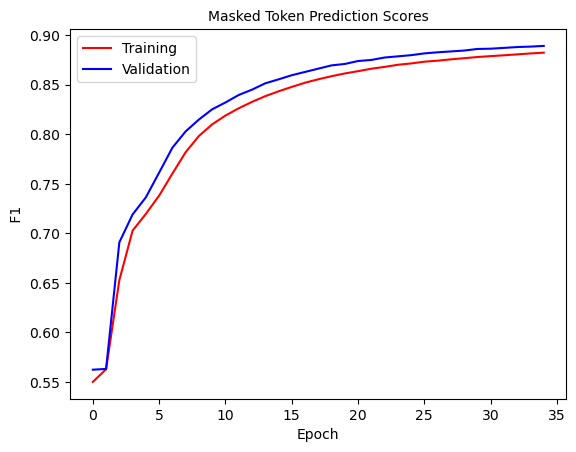

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 35: 100%|██████████| 445/445 [09:07<00:00,  1.23s/it, loss=0.353]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.87885333045346   Masked Token f1 0.8830242953018008     SEQ F1 0.9824722385801772


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8462892963632522    v_masked_token_ F1:  0.8896342395054443  V SEQ F1:  0.983651756966482


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


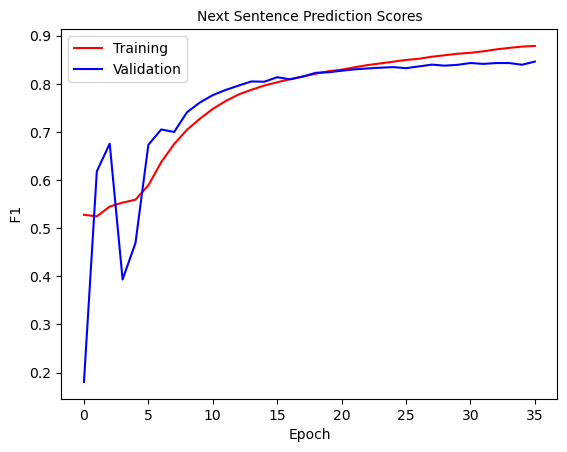

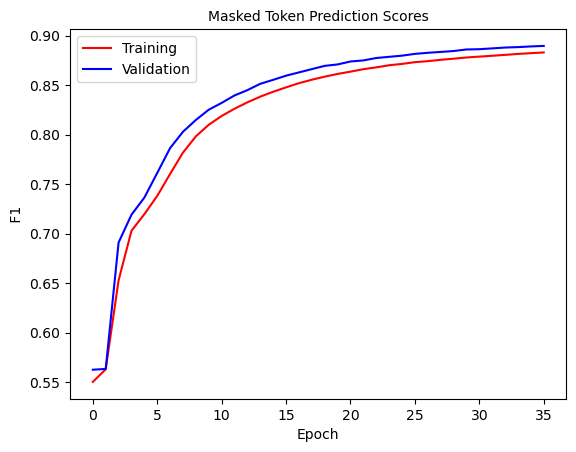

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 36: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.22] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8830489669855168   Masked Token f1 0.8834824561388184     SEQ F1 0.9825711209441491


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8447772620699555    v_masked_token_ F1:  0.8906988765449432  V SEQ F1:  0.983738450720105


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


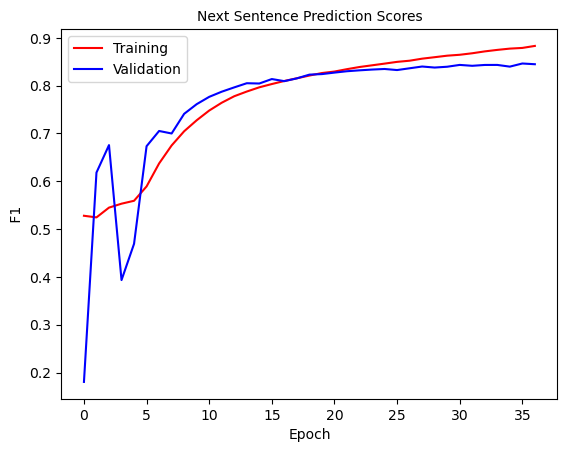

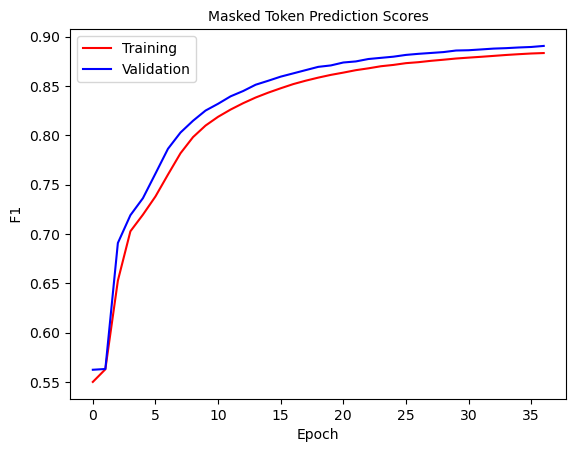

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 37: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.401]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8854196677230385   Masked Token f1 0.8841206154891647     SEQ F1 0.9826845812746137


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8388501529051988    v_masked_token_ F1:  0.8908894169172182  V SEQ F1:  0.9838353865564755


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


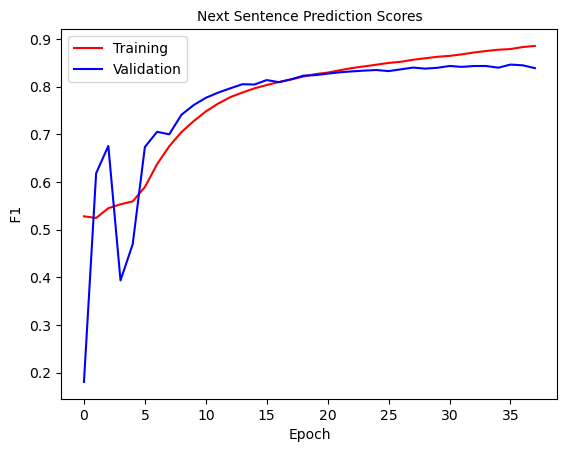

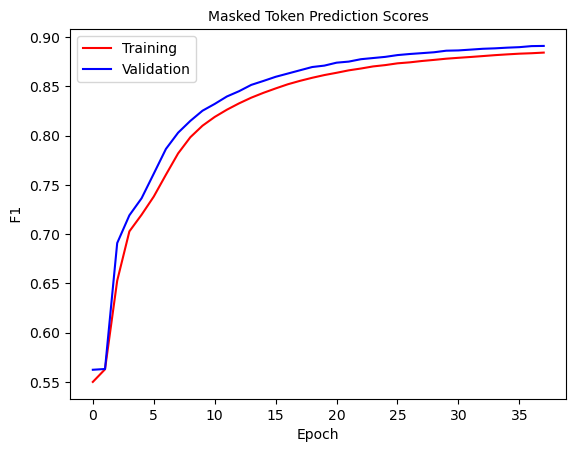

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 38: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.354]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.888627483930597   Masked Token f1 0.8846359254704609     SEQ F1 0.9827675061374539


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8438270113553998    v_masked_token_ F1:  0.8911412320016296  V SEQ F1:  0.9838915638472698


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


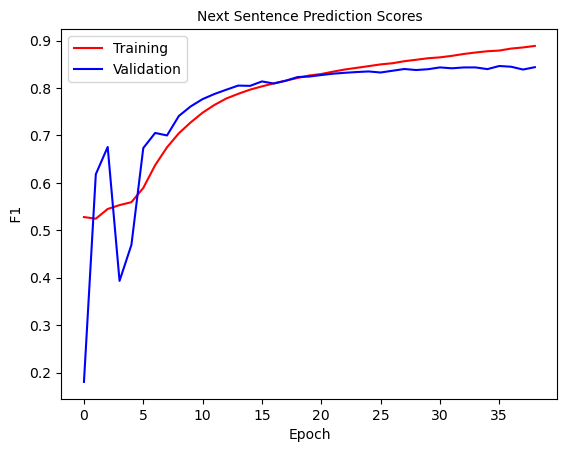

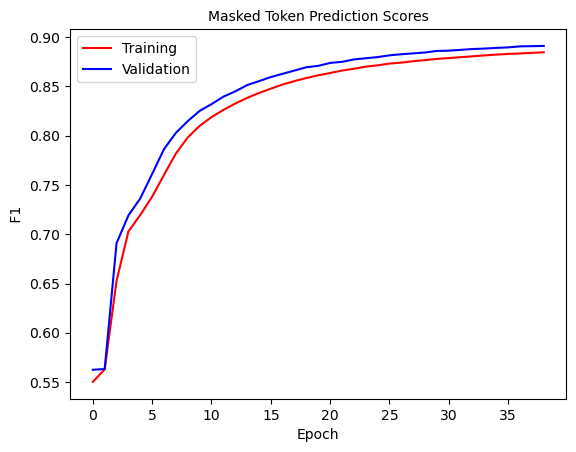

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 39: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.23] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8910994450277486   Masked Token f1 0.8853040753603263     SEQ F1 0.9828937576786977


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8485249309114958    v_masked_token_ F1:  0.8919208387368919  V SEQ F1:  0.9839980246980957


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


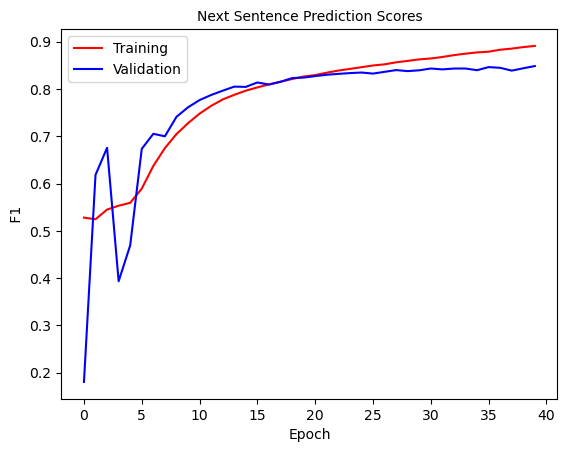

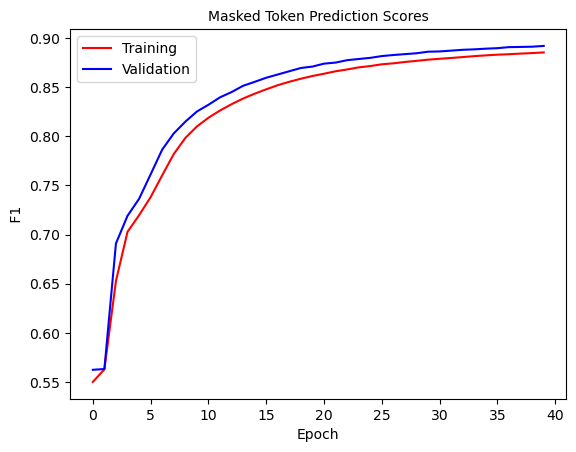

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 40: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.306]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.8933887220433878   Masked Token f1 0.8856903263377497     SEQ F1 0.9829795903692261


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8457584156539455    v_masked_token_ F1:  0.8922863287882766  V SEQ F1:  0.9840651897172101


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


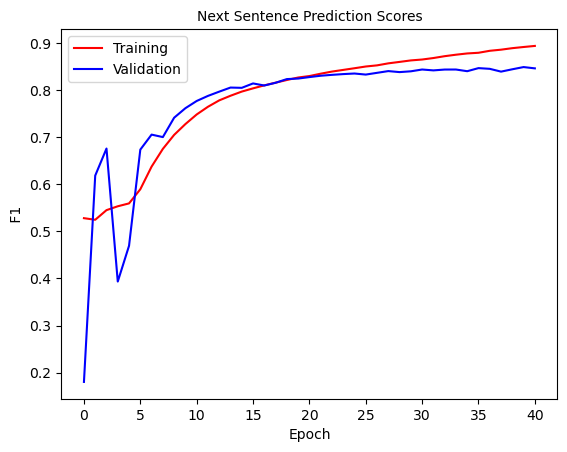

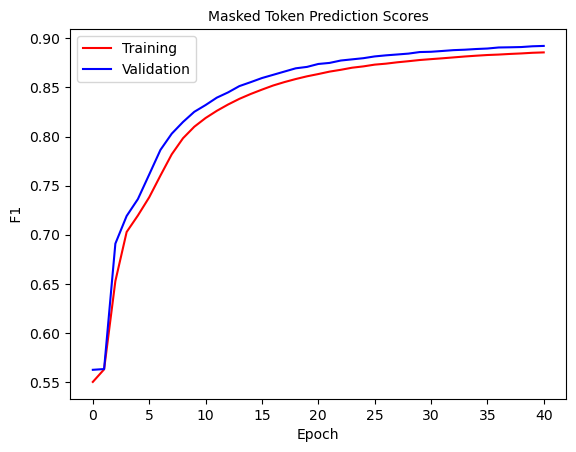

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 41: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.318]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8961433580054539   Masked Token f1 0.88636762850043     SEQ F1 0.9830802032813024


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8463713477851084    v_masked_token_ F1:  0.8928919445937296  V SEQ F1:  0.9841471114914012


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


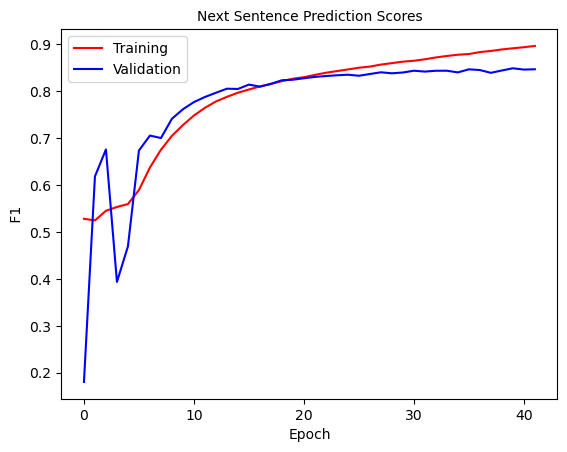

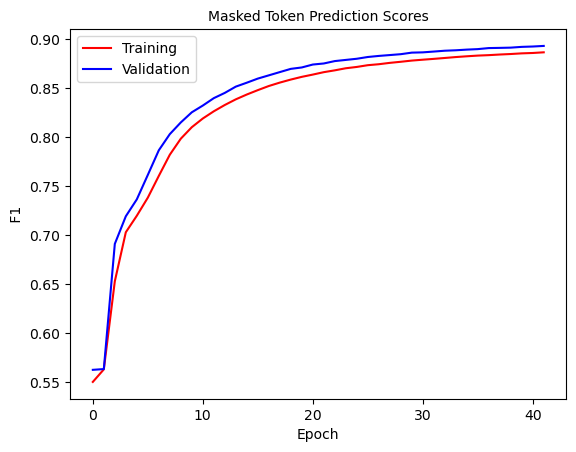

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 42: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.177]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.8981227462772393   Masked Token f1 0.8867657240460435     SEQ F1 0.9831572401571056


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8419726160184176    v_masked_token_ F1:  0.8928212668755092  V SEQ F1:  0.9841603448570625


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


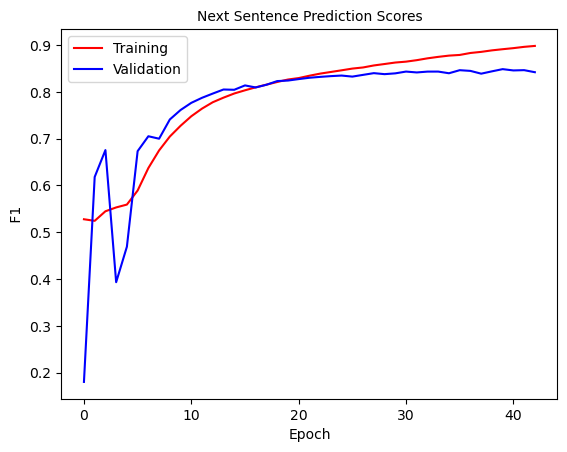

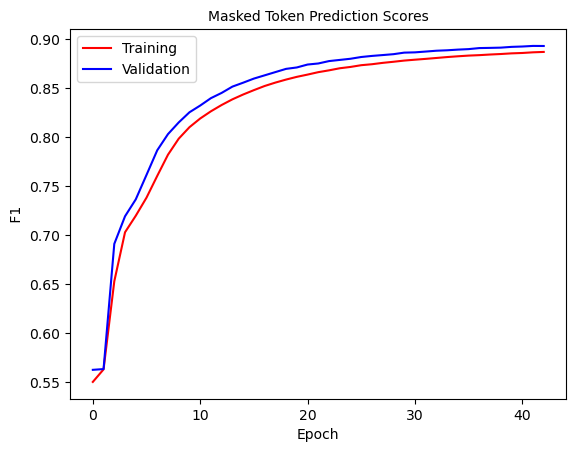

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 43: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.361]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9002659255887496   Masked Token f1 0.8871109350170817     SEQ F1 0.9832180622823258


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8465855050408978    v_masked_token_ F1:  0.8935001543275453  V SEQ F1:  0.9842627992285772


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


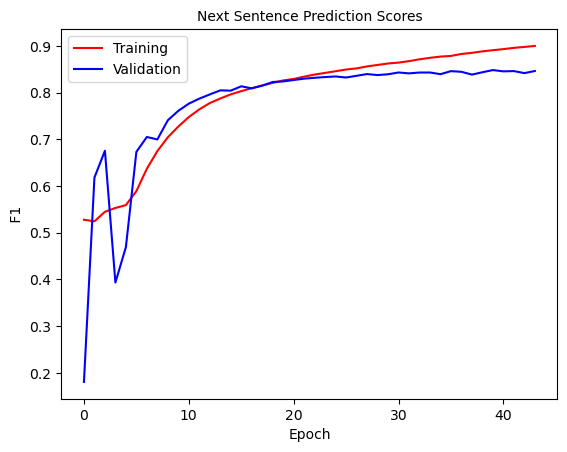

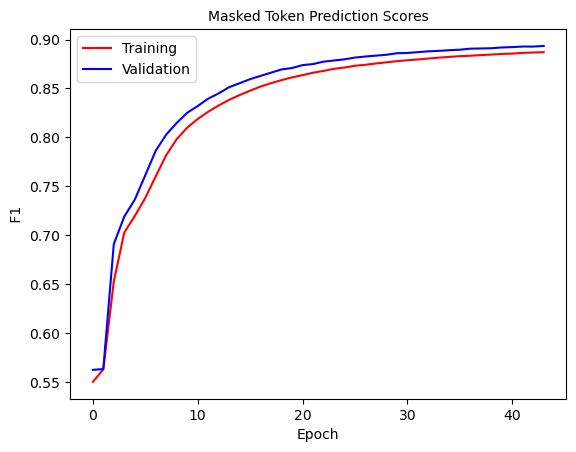

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 44: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.258]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9036229714354153   Masked Token f1 0.8876507819431001     SEQ F1 0.9833200673890006


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8476308817668159    v_masked_token_ F1:  0.8938635118374031  V SEQ F1:  0.9842962978255064


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


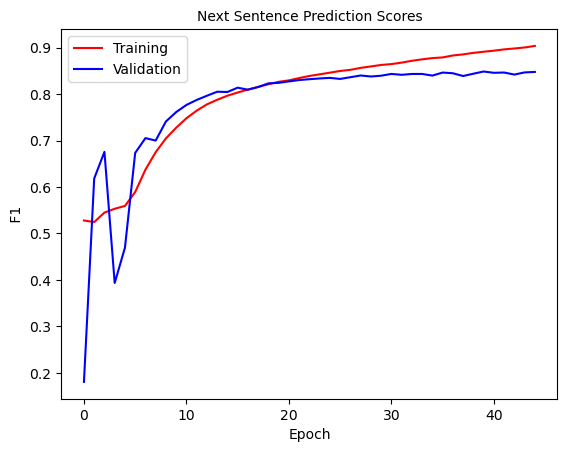

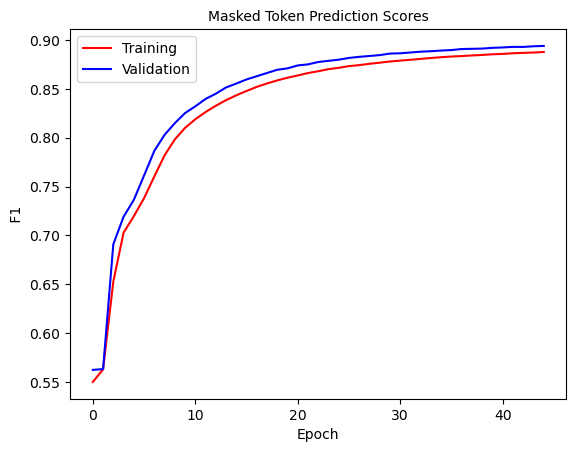

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 45: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.253]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9065137493864553   Masked Token f1 0.8877937738009799     SEQ F1 0.9833606033648635


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8490734224724372    v_masked_token_ F1:  0.8942643252736711  V SEQ F1:  0.9844022817384153


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


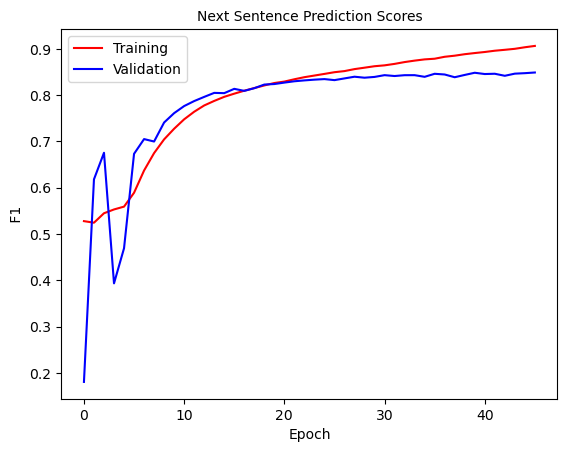

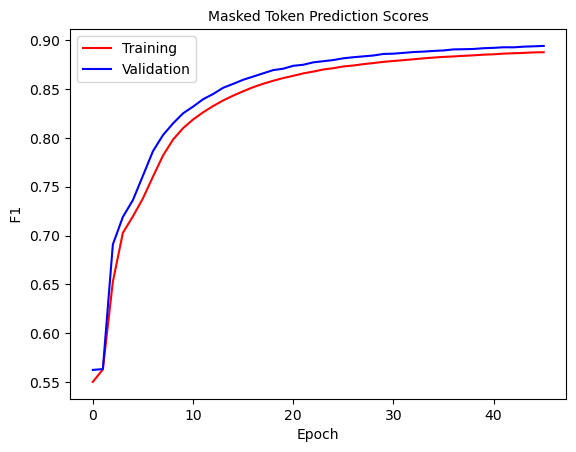

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 46: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.324]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9090244881092832   Masked Token f1 0.8884429442763558     SEQ F1 0.9834596425945358


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8482142857142857    v_masked_token_ F1:  0.8945835006546324  V SEQ F1:  0.9844284550337897


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


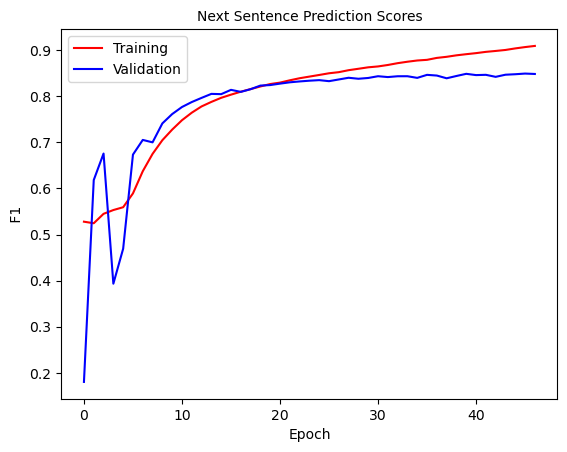

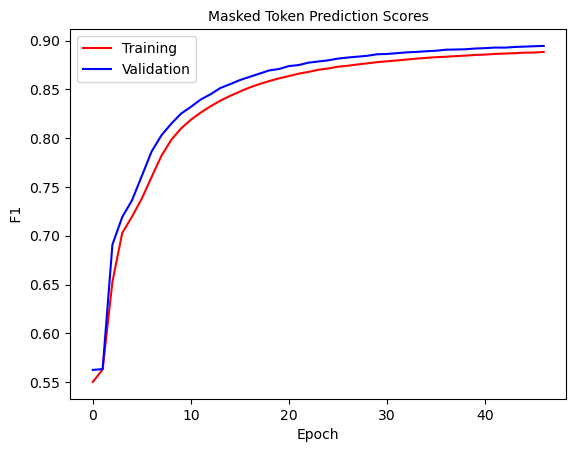

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 47: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.286]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9102941528445945   Masked Token f1 0.8888936427863284     SEQ F1 0.9835300113101376


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8482045443764528    v_masked_token_ F1:  0.8946954059385157  V SEQ F1:  0.9844875704218099


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


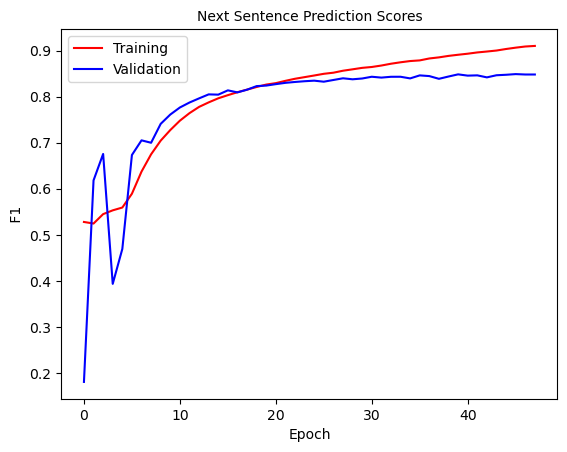

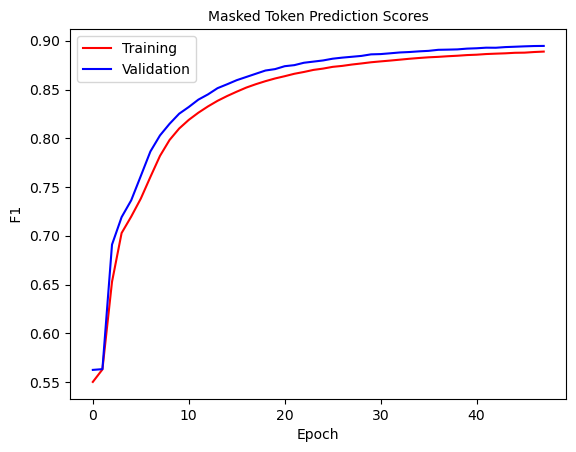

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 48: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.248]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9119383610401575   Masked Token f1 0.889098547814431     SEQ F1 0.9835816226969532


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8487470026799567    v_masked_token_ F1:  0.8948263333213384  V SEQ F1:  0.9845664522246037


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


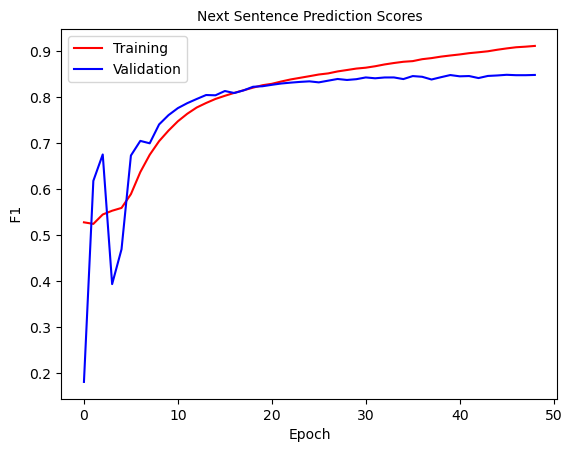

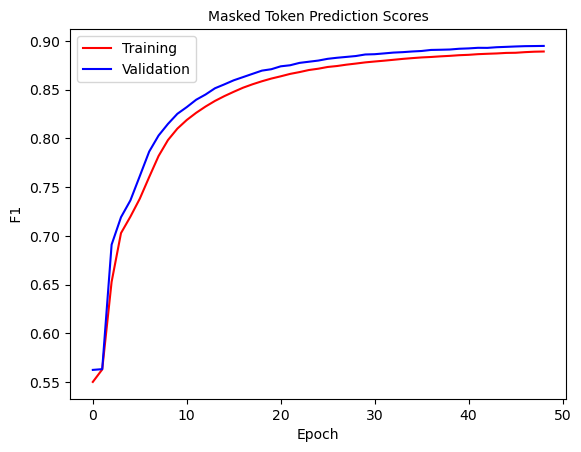

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 49: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.207]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9149340407226842   Masked Token f1 0.8896668850620393     SEQ F1 0.9836791257213956


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8499894704822519    v_masked_token_ F1:  0.8954008722285688  V SEQ F1:  0.9846152325359344


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


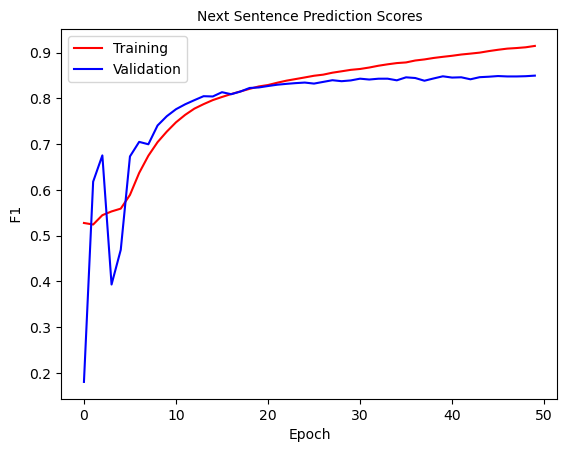

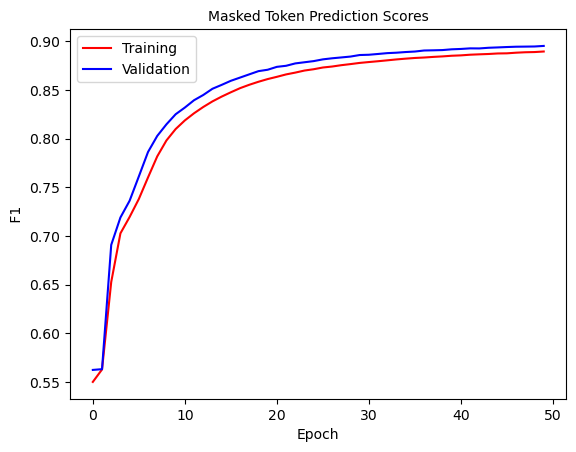

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 50: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.165]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9167164750041839   Masked Token f1 0.8897792843849213     SEQ F1 0.9837054145404196


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8481828012600499    v_masked_token_ F1:  0.8956779085421327  V SEQ F1:  0.9846430557483773


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


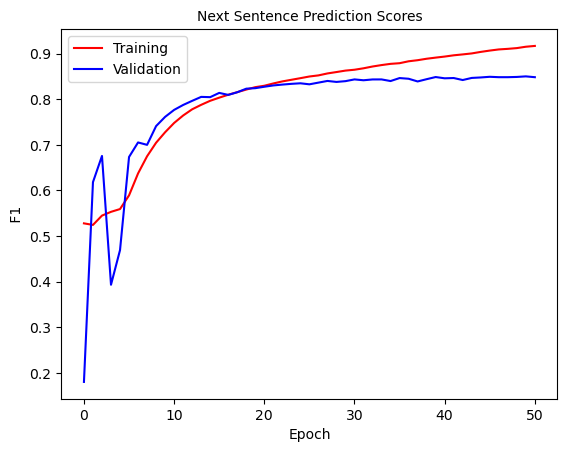

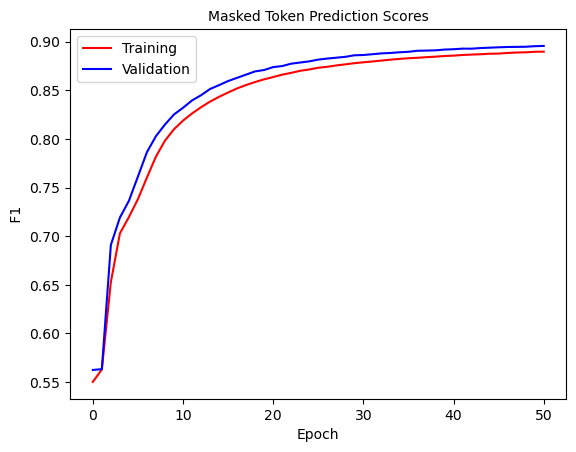

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 51: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.298]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9198315261224124   Masked Token f1 0.8901283406114001     SEQ F1 0.9837634033519278


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8483041896491023    v_masked_token_ F1:  0.8958348472944893  V SEQ F1:  0.9847163985185877


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


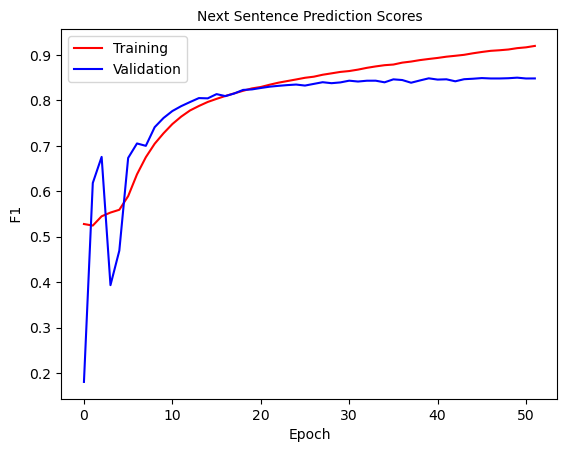

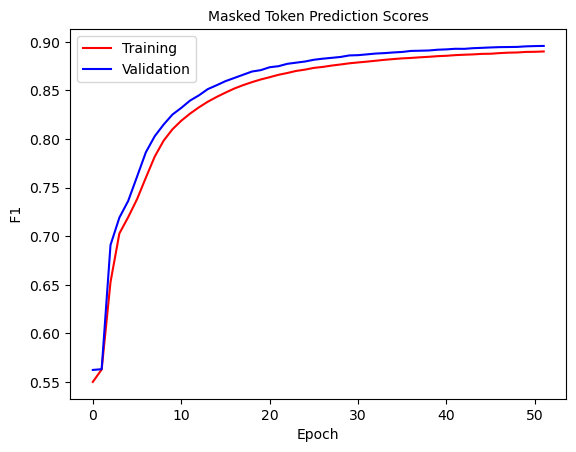

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 52: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.253]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9210279228041217   Masked Token f1 0.8905413528002933     SEQ F1 0.9838393597593832


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8476601393959509    v_masked_token_ F1:  0.8963300380109903  V SEQ F1:  0.984765573464695


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


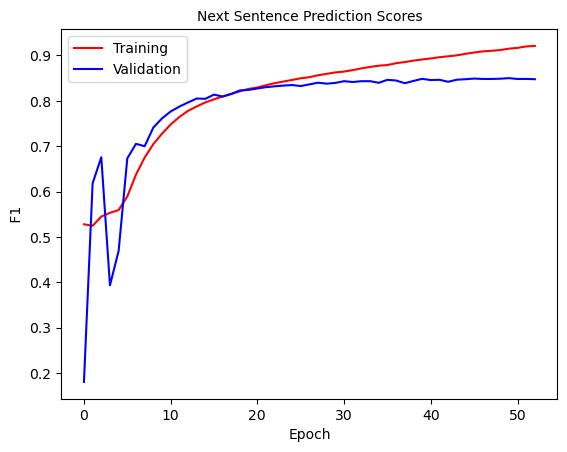

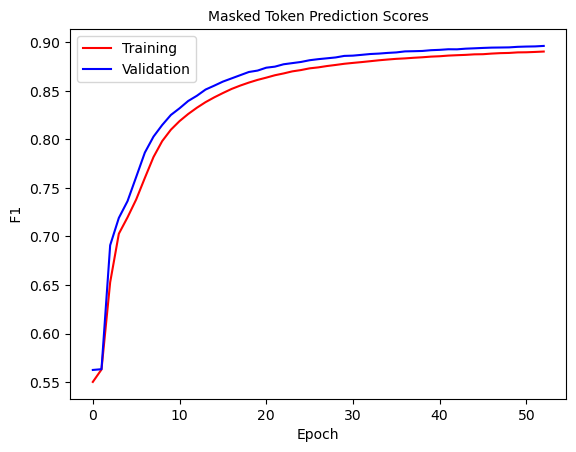

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 53: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.242]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9239930783459633   Masked Token f1 0.8908206988804369     SEQ F1 0.9838825809042946


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8464501402824671    v_masked_token_ F1:  0.8963810955892024  V SEQ F1:  0.9848113035608639


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


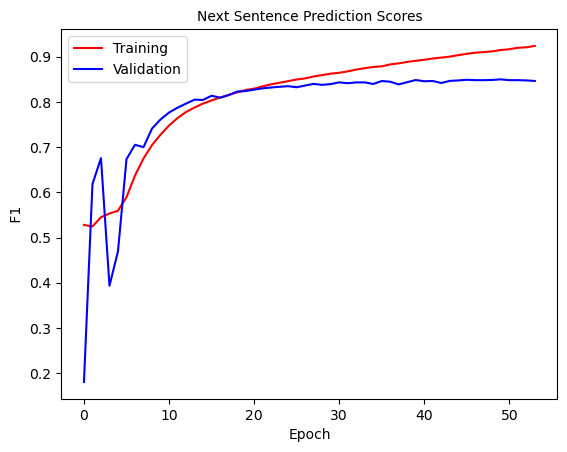

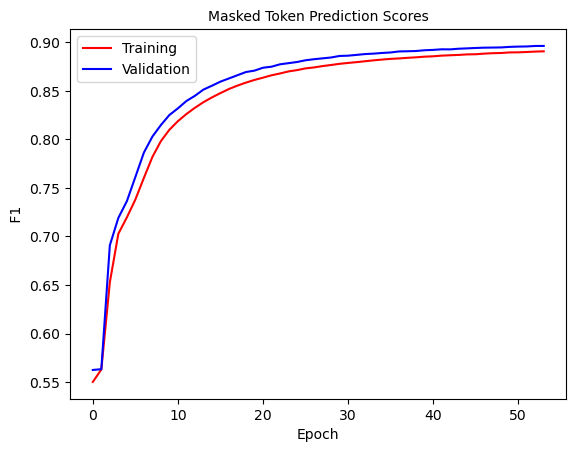

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 54: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.155]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9252818650869482   Masked Token f1 0.8912171288149662     SEQ F1 0.9839612134624783


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8475905332192757    v_masked_token_ F1:  0.8966517986070868  V SEQ F1:  0.984825723083191


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


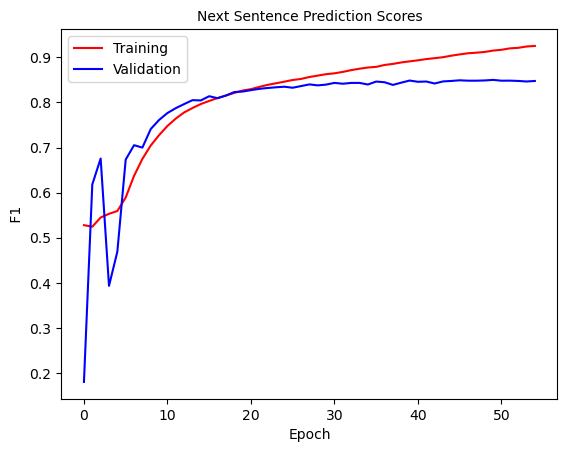

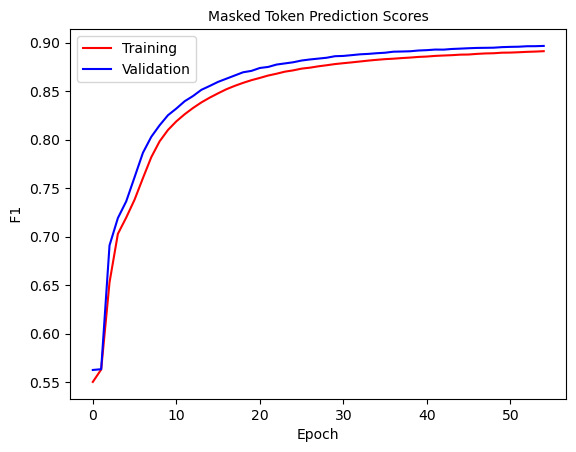

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 55: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.27] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9278129101539195   Masked Token f1 0.8913744645121574     SEQ F1 0.9839851232728734


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8480178300455236    v_masked_token_ F1:  0.8971354000362602  V SEQ F1:  0.9848965567440904


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


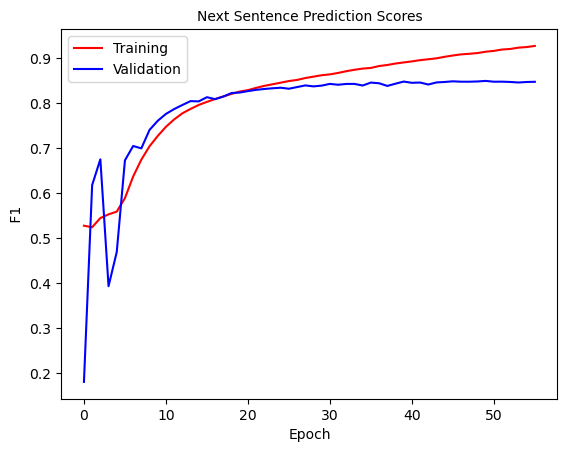

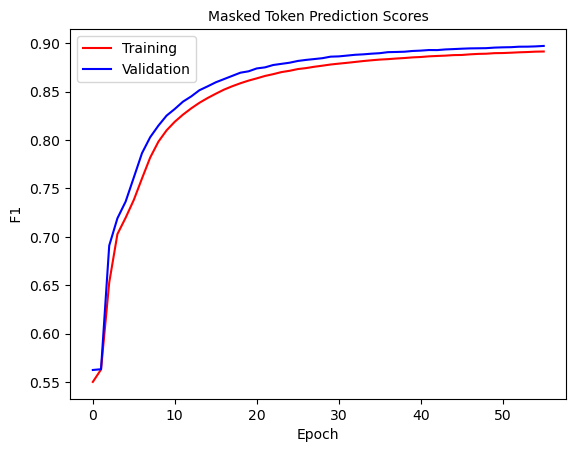

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 56: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.353]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.930408697570954   Masked Token f1 0.8916013853137139     SEQ F1 0.9840430324889933


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.848871119473189    v_masked_token_ F1:  0.8970995430104798  V SEQ F1:  0.9849073198709113


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


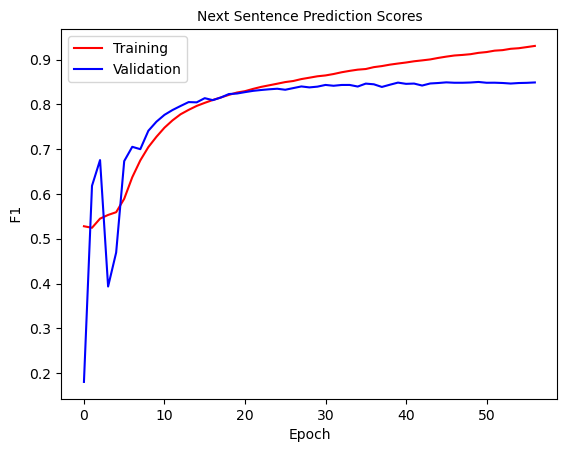

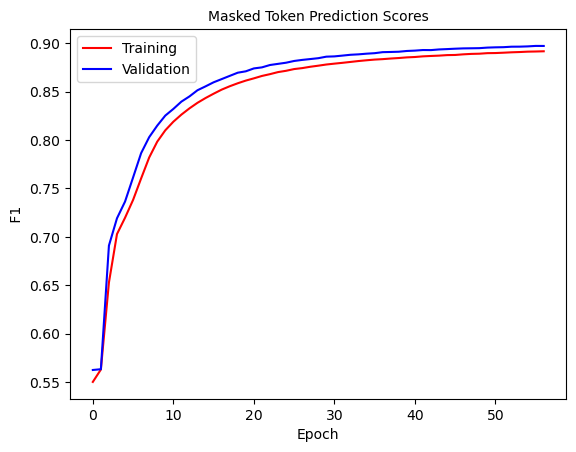

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 57: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.168]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9320352462828049   Masked Token f1 0.891993050899076     SEQ F1 0.9840975687742365


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8488162001079381    v_masked_token_ F1:  0.8972945587898556  V SEQ F1:  0.9849656823998194


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


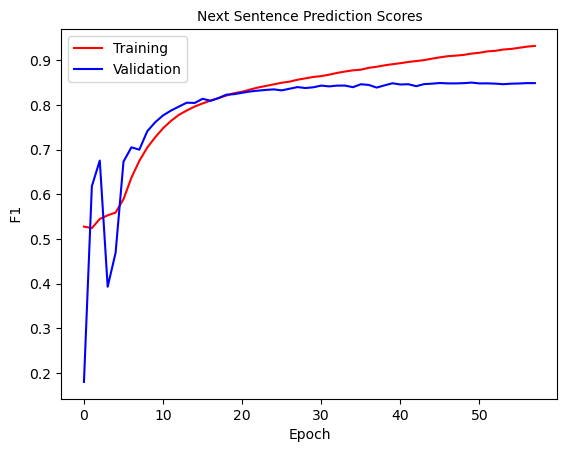

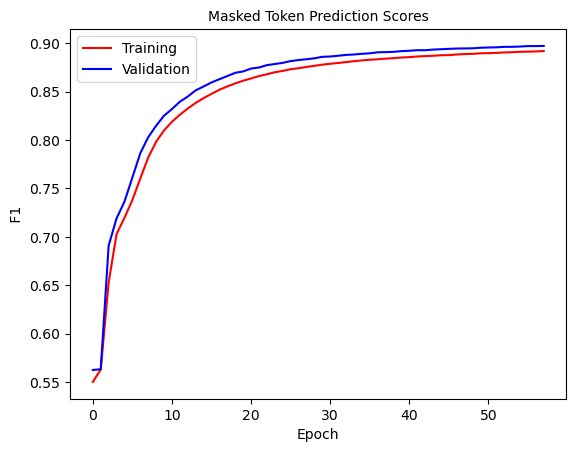

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 58: 100%|██████████| 445/445 [09:07<00:00,  1.23s/it, loss=0.175]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9339802584521482   Masked Token f1 0.8921886364506253     SEQ F1 0.9841271275657424


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8492074624772058    v_masked_token_ F1:  0.8976480749978825  V SEQ F1:  0.9850050971038271


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


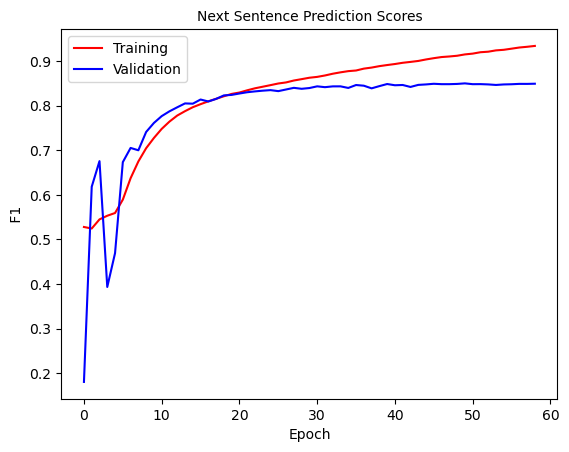

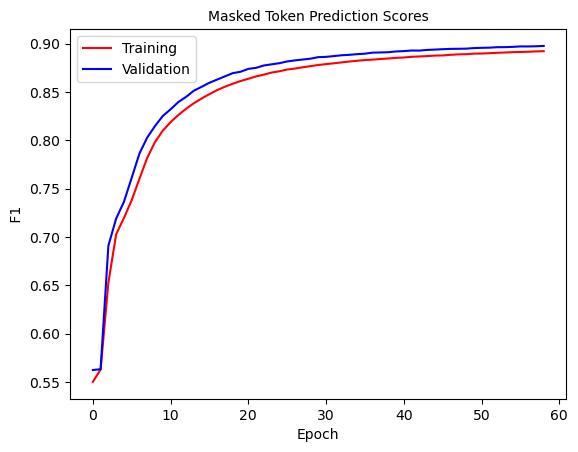

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 59: 100%|██████████| 445/445 [09:07<00:00,  1.23s/it, loss=0.316]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9356136700982993   Masked Token f1 0.8924708688058411     SEQ F1 0.9841903926131398


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8482174126216993    v_masked_token_ F1:  0.8978690847184436  V SEQ F1:  0.9850501308774152


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


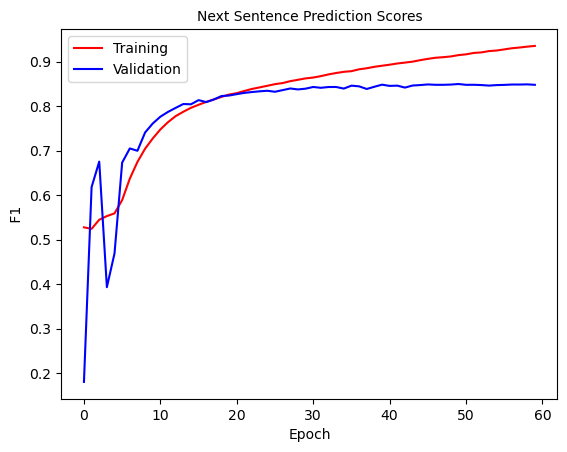

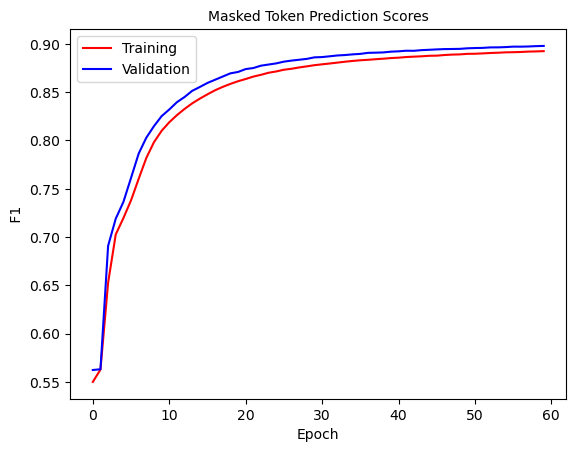

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 60: 100%|██████████| 445/445 [09:06<00:00,  1.23s/it, loss=0.155]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9368011580596544   Masked Token f1 0.8927688472617145     SEQ F1 0.9842427362460073


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.18it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8467651480800897    v_masked_token_ F1:  0.8983223818147082  V SEQ F1:  0.9851065834472491


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


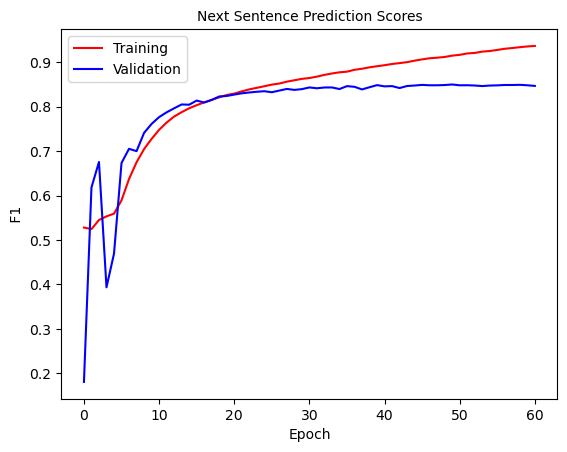

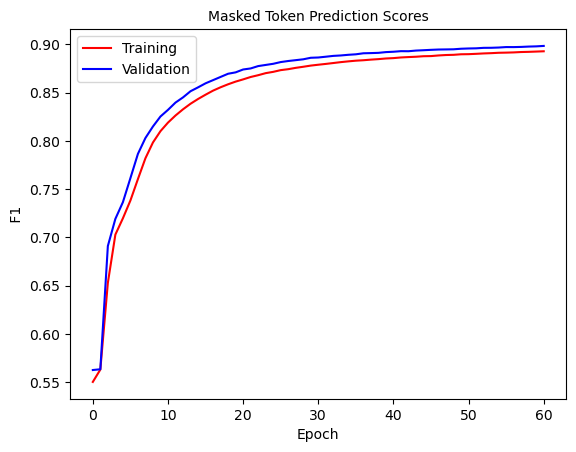

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 61: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.254]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9391951866082864   Masked Token f1 0.8929745524562389     SEQ F1 0.984261441146276


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8490539395650946    v_masked_token_ F1:  0.8985129587523977  V SEQ F1:  0.9851164133706395


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


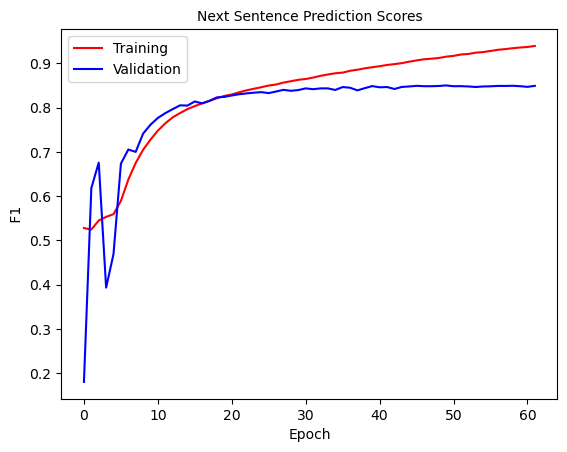

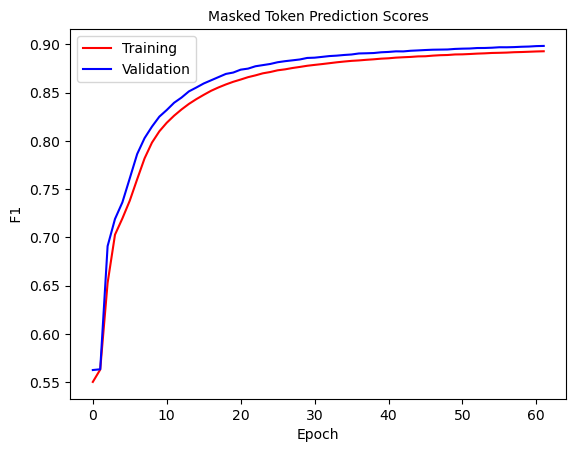

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 62: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.294]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9409977480966054   Masked Token f1 0.8932687035114031     SEQ F1 0.9843229232342303


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.846044595938077    v_masked_token_ F1:  0.8988920763439779  V SEQ F1:  0.9851784963776957


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


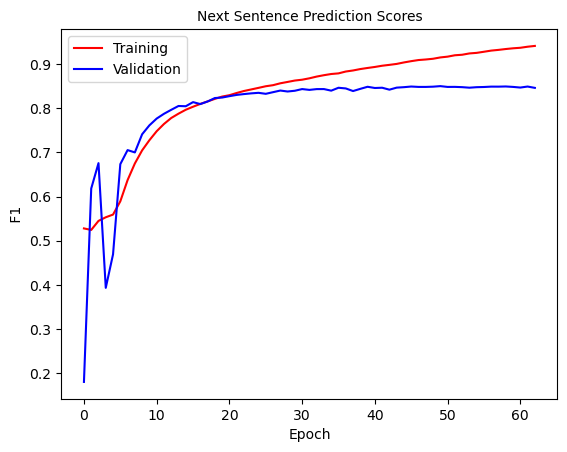

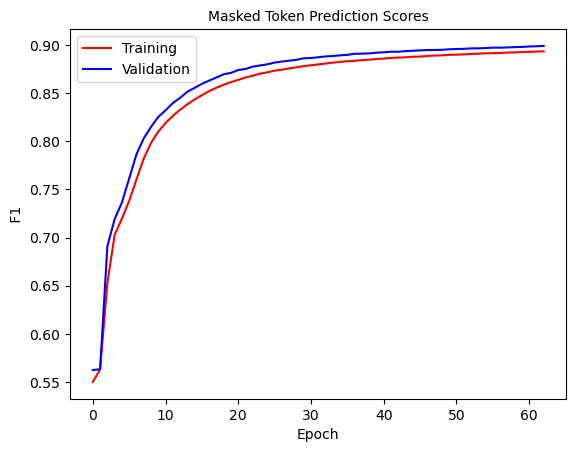

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 63: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.178]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9422843401033358   Masked Token f1 0.8935098521984245     SEQ F1 0.98436072140466


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8472016373773731    v_masked_token_ F1:  0.8991277479473789  V SEQ F1:  0.9851875331210479


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


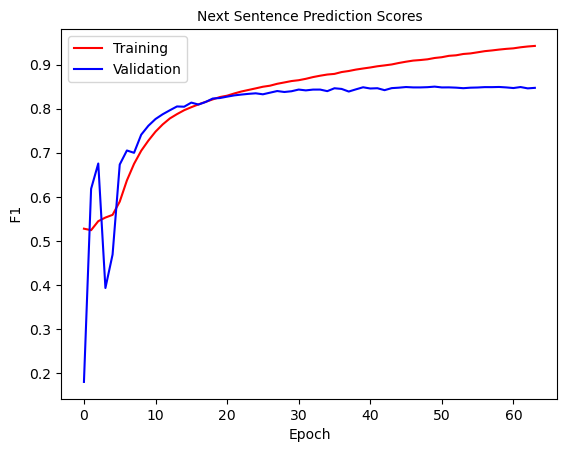

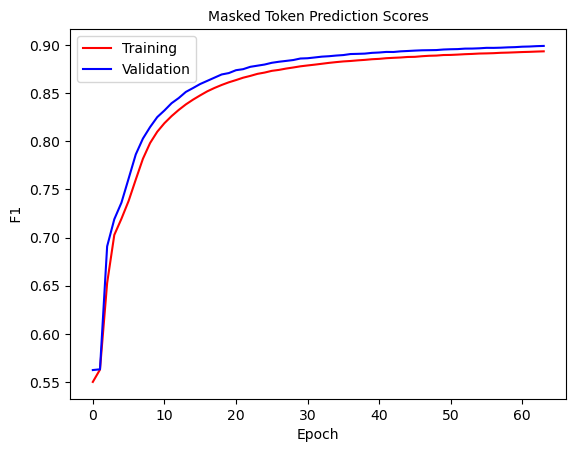

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 64: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.201]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9442796068474661   Masked Token f1 0.8936292309151475     SEQ F1 0.9843857304223355


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8471079280005691    v_masked_token_ F1:  0.8989222644359478  V SEQ F1:  0.9851779639760447


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


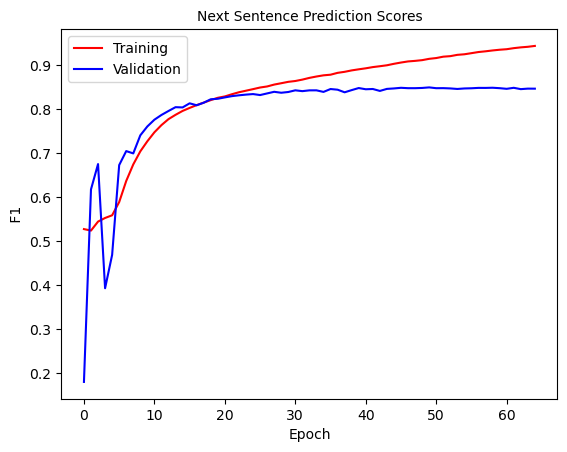

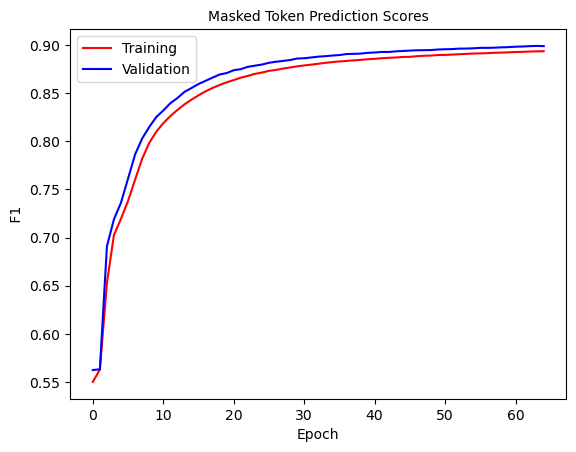

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 65: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.148]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9466535842773467   Masked Token f1 0.8940837359205493     SEQ F1 0.9844624921687495


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8474393277942074    v_masked_token_ F1:  0.899187224114752  V SEQ F1:  0.9852464891640058


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


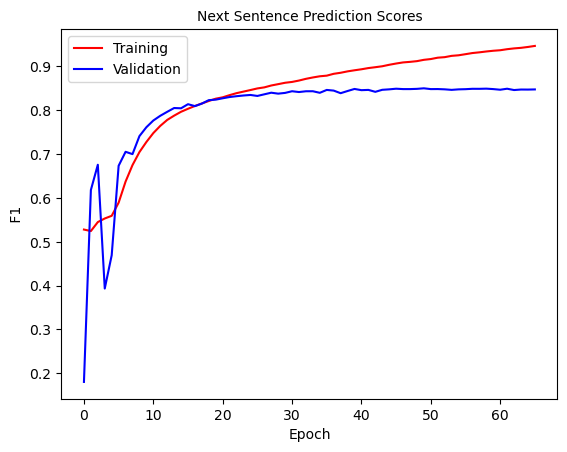

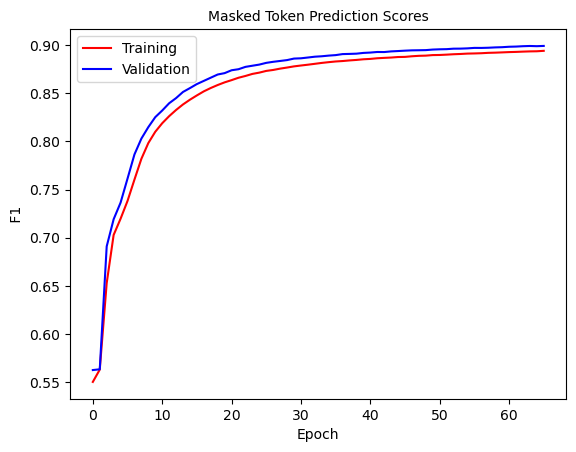

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 66: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.19] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.947738257307786   Masked Token f1 0.894095960341539     SEQ F1 0.9844722708745332


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8472724693197135    v_masked_token_ F1:  0.8995196749468505  V SEQ F1:  0.9852793934984789


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


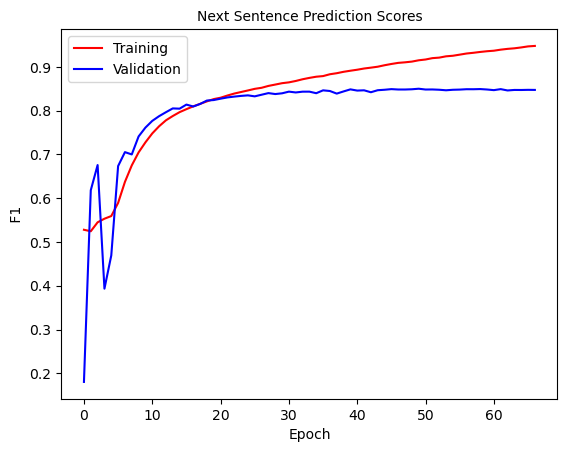

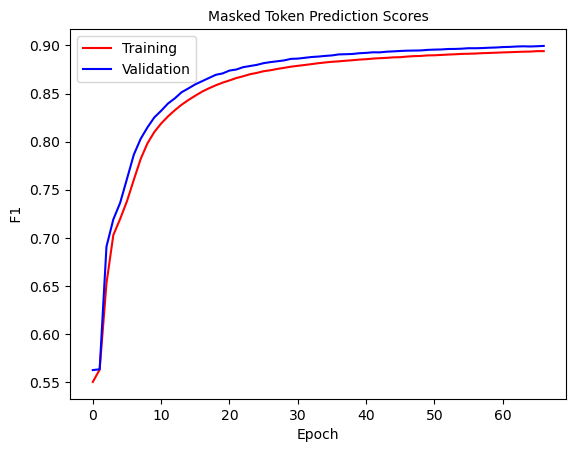

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 67: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.217]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9489861994807726   Masked Token f1 0.8943949115885882     SEQ F1 0.9845282715209597


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8496673849901621    v_masked_token_ F1:  0.8996370772249644  V SEQ F1:  0.9853192026382693


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


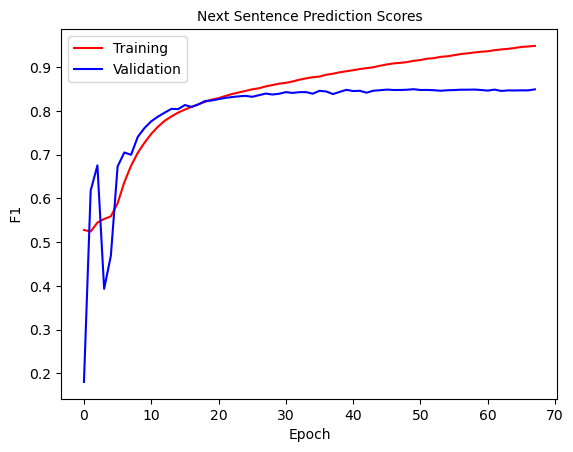

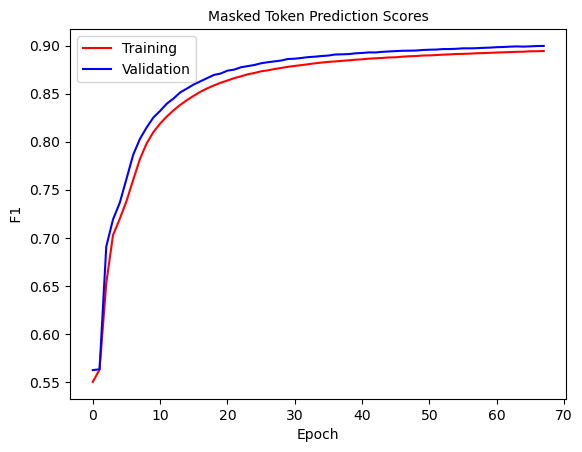

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 68: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.206]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9505472956109388   Masked Token f1 0.8947967160623342     SEQ F1 0.9845802716520595


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8493946506169684    v_masked_token_ F1:  0.8996261883490645  V SEQ F1:  0.9853594284418371


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


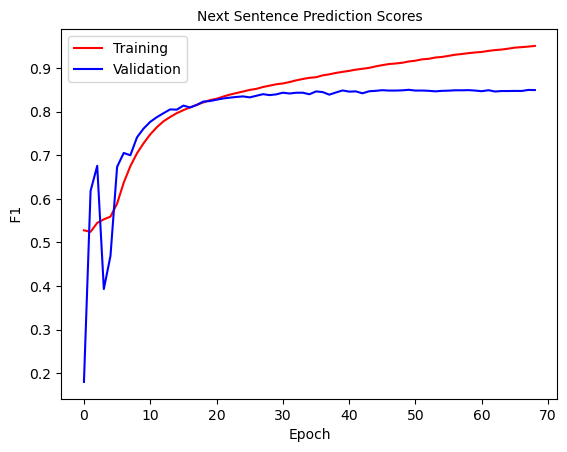

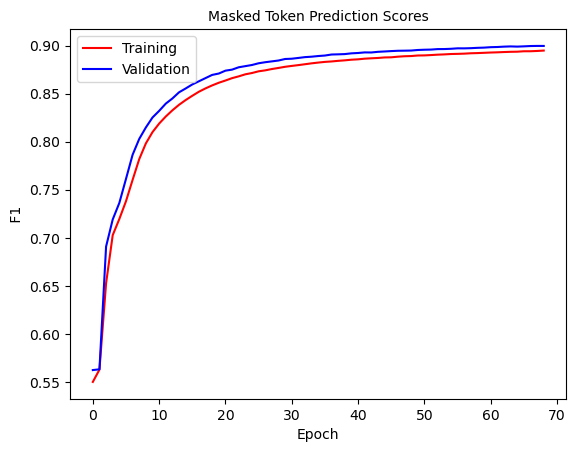

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 69: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.33] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9524103611681849   Masked Token f1 0.8948713134373505     SEQ F1 0.9846103123436423


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8494656345735601    v_masked_token_ F1:  0.8998840513865877  V SEQ F1:  0.9853764867750419


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


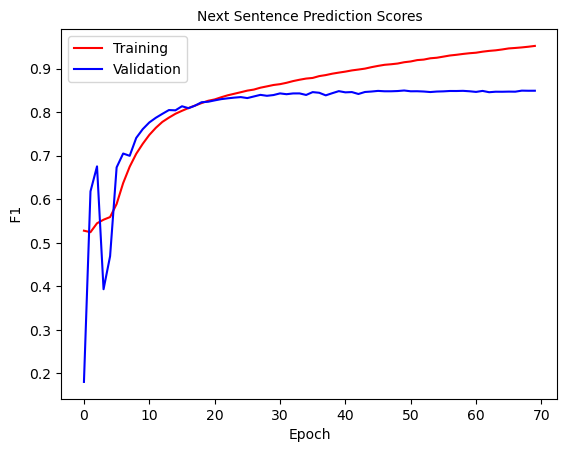

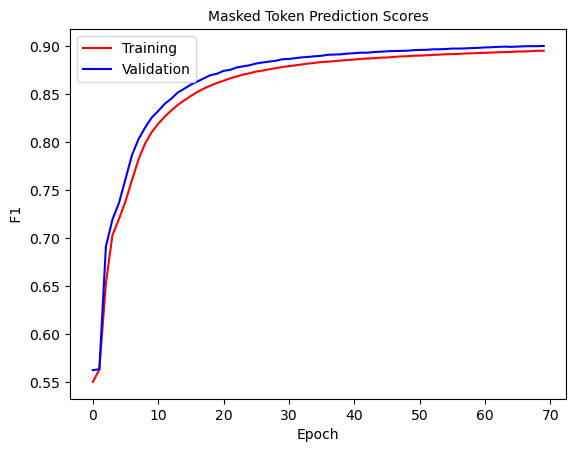

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 70: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.11] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9522954435994554   Masked Token f1 0.895090776376998     SEQ F1 0.9846456340661034


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8495955093280502    v_masked_token_ F1:  0.9003156567478452  V SEQ F1:  0.9854271911581953


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


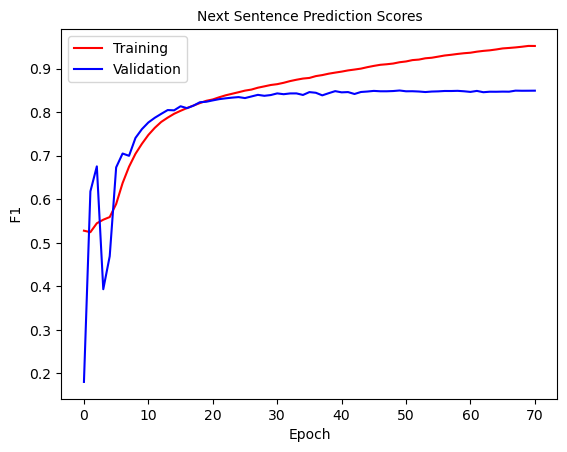

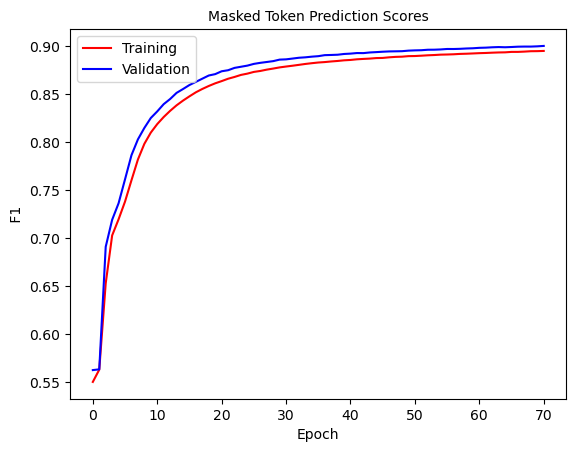

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 71: 100%|██████████| 445/445 [09:08<00:00,  1.23s/it, loss=0.186]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to

Training:   Instruction f1:  0.9547971575920337   Masked Token f1 0.8953553646732297     SEQ F1 0.9846839153704332


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8468646864686469    v_masked_token_ F1:  0.900111623318166  V SEQ F1:  0.9854410792302509


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


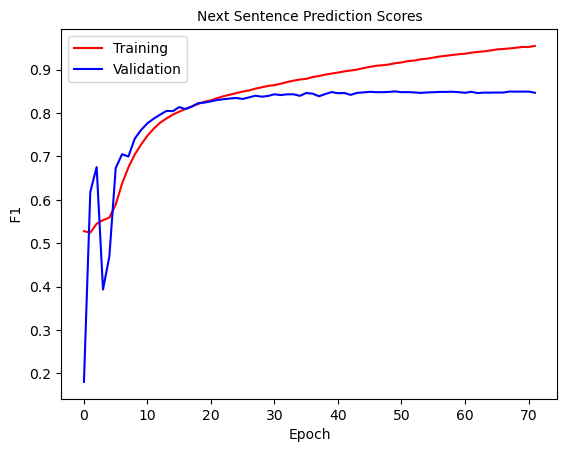

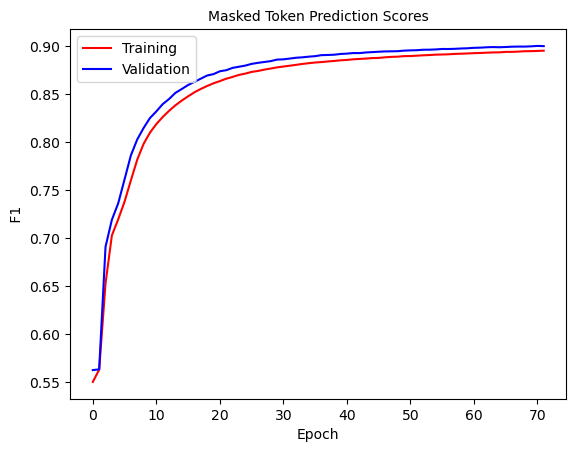

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 72: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.181]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9558673408826531   Masked Token f1 0.8955698977558073     SEQ F1 0.9847238395574434


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8480663634435462    v_masked_token_ F1:  0.9007110462045267  V SEQ F1:  0.9855034961699861


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


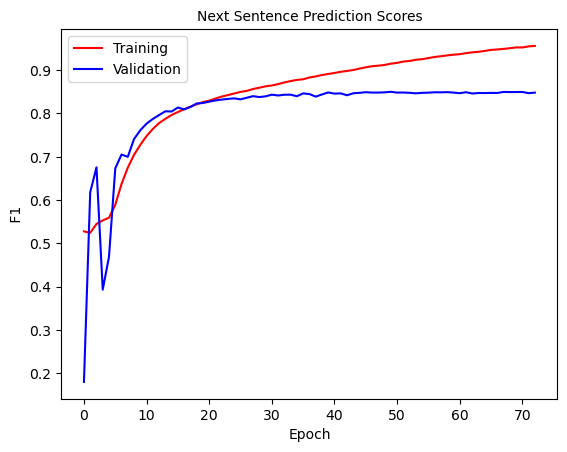

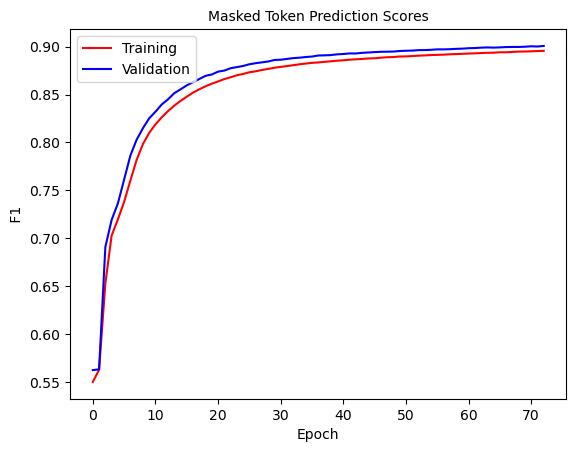

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 73: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.125]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9570217917675545   Masked Token f1 0.8957388992292804     SEQ F1 0.9847562236301193


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8484480463367354    v_masked_token_ F1:  0.900896526068487  V SEQ F1:  0.9855246984233534


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


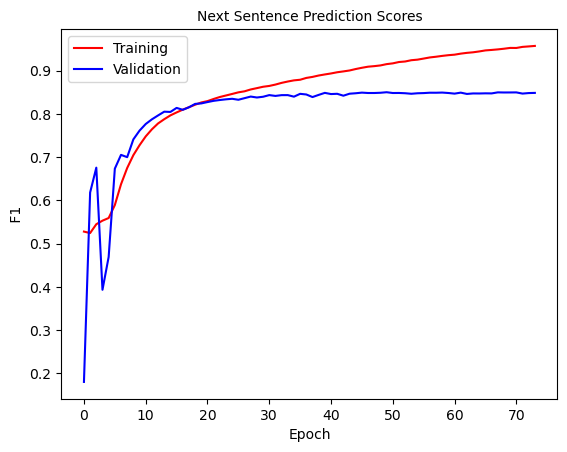

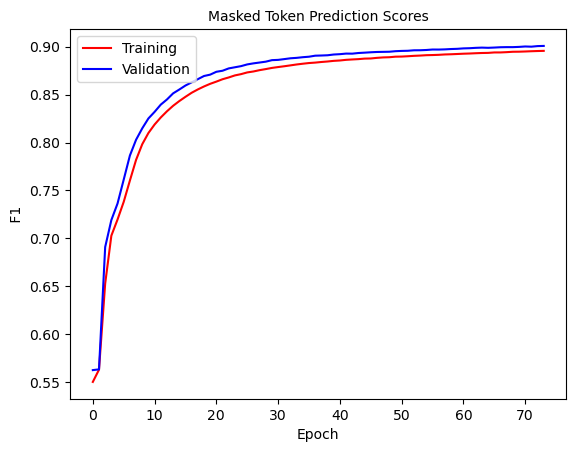

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 74: 100%|██████████| 445/445 [09:14<00:00,  1.25s/it, loss=0.124]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.958459210018696   Masked Token f1 0.8959736827318334     SEQ F1 0.9847957427187057


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8481336367688806    v_masked_token_ F1:  0.900820840168524  V SEQ F1:  0.9855477514701474


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


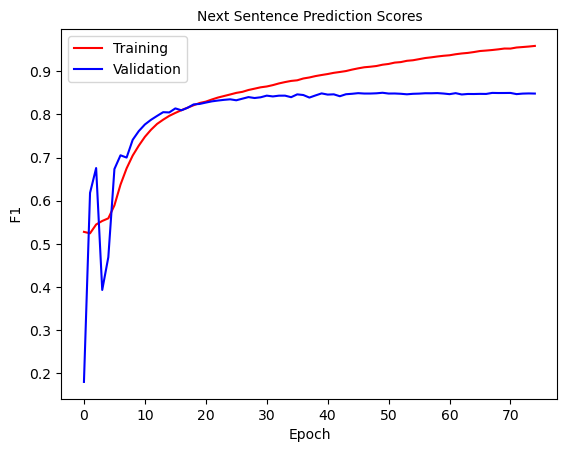

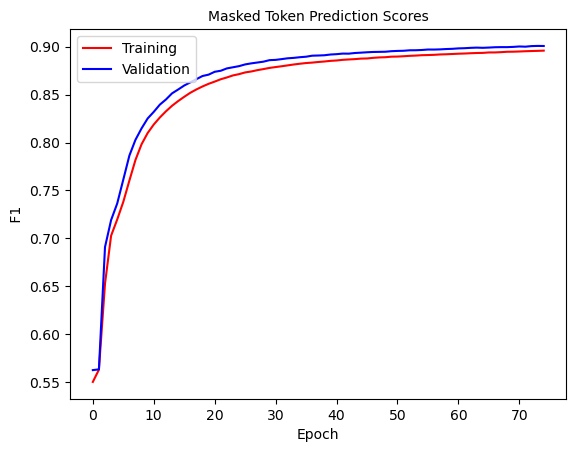

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 75: 100%|██████████| 445/445 [09:15<00:00,  1.25s/it, loss=0.0802]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9593627104971262   Masked Token f1 0.8960316504878594     SEQ F1 0.9848153234918812


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.13it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8486211663269371    v_masked_token_ F1:  0.9010700785185126  V SEQ F1:  0.985549522237542


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


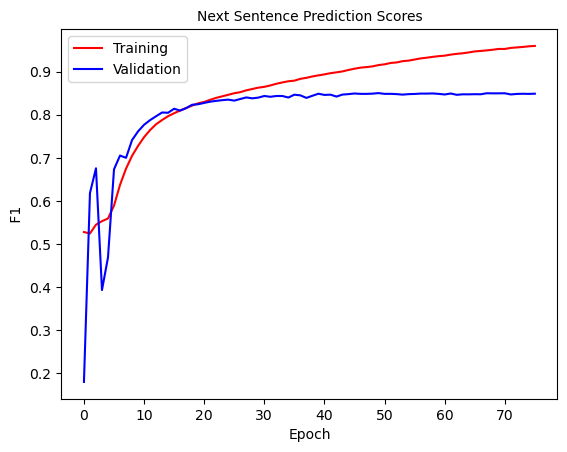

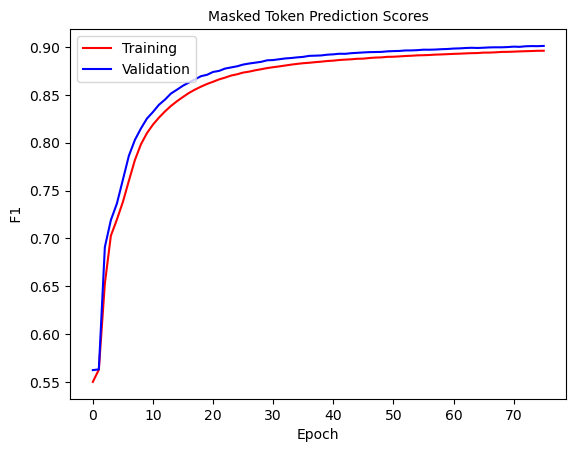

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 76: 100%|██████████| 445/445 [09:15<00:00,  1.25s/it, loss=0.148] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9610897941513116   Masked Token f1 0.8963067217726481     SEQ F1 0.9848562121735175


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8483850478722152    v_masked_token_ F1:  0.9012425576685703  V SEQ F1:  0.9855908898879296


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


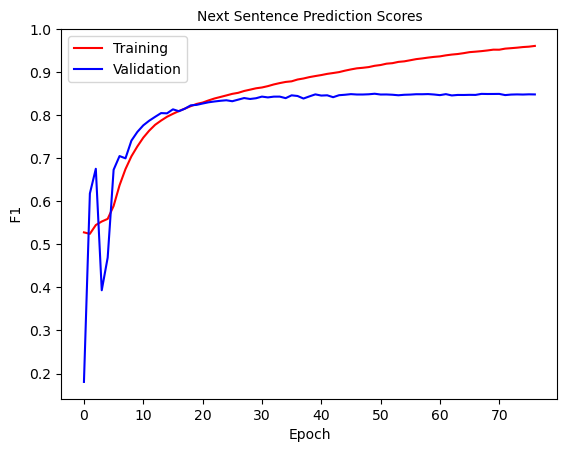

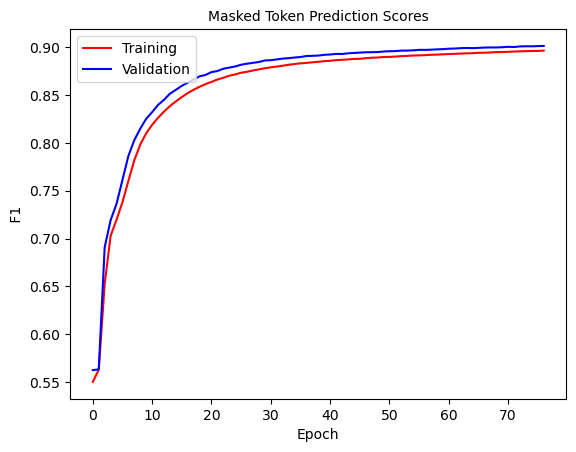

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 77: 100%|██████████| 445/445 [09:14<00:00,  1.25s/it, loss=0.0684]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9627573773602809   Masked Token f1 0.8963577028586484     SEQ F1 0.9848621656231448


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8450030772144108    v_masked_token_ F1:  0.9015346813624003  V SEQ F1:  0.9856516979200967


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


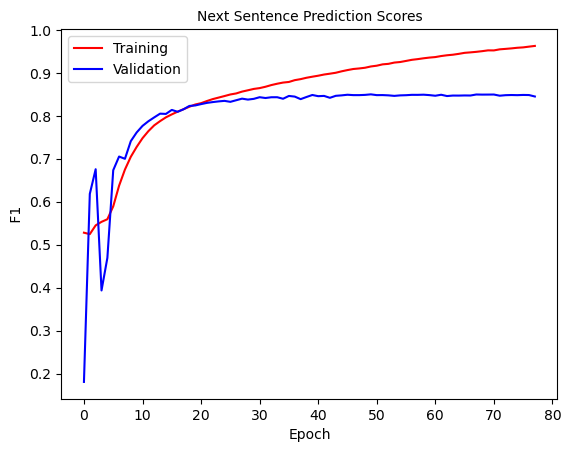

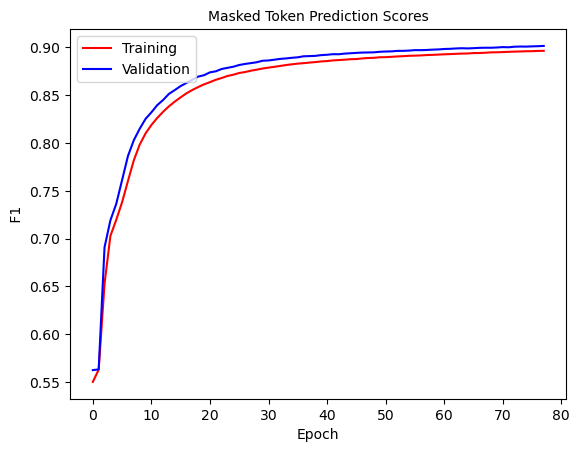

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 78: 100%|██████████| 445/445 [09:14<00:00,  1.25s/it, loss=0.0842]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9629467196112131   Masked Token f1 0.8967300641138917     SEQ F1 0.9849258061146013


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8472017759084005    v_masked_token_ F1:  0.9019037790164055  V SEQ F1:  0.9856822163438246


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


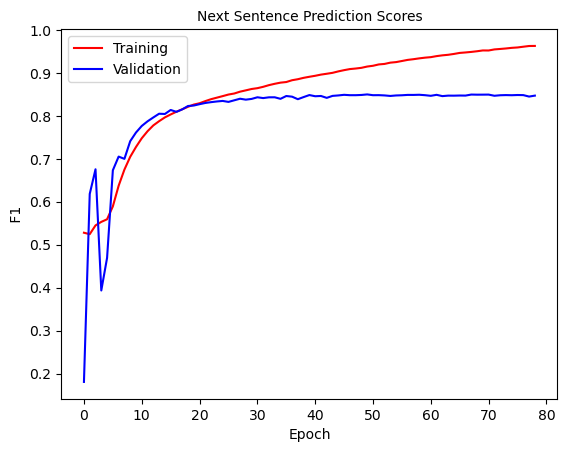

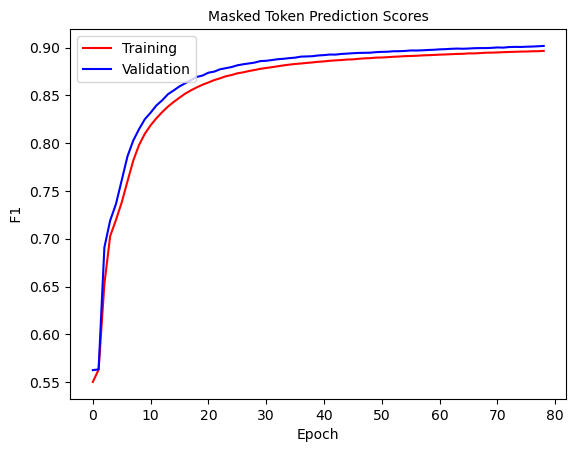

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 79: 100%|██████████| 445/445 [09:15<00:00,  1.25s/it, loss=0.234]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

Training:   Instruction f1:  0.9644547937738118   Masked Token f1 0.8970159591960051     SEQ F1 0.9849663063149539


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8469161436458874    v_masked_token_ F1:  0.9016681432096657  V SEQ F1:  0.985686305269108


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


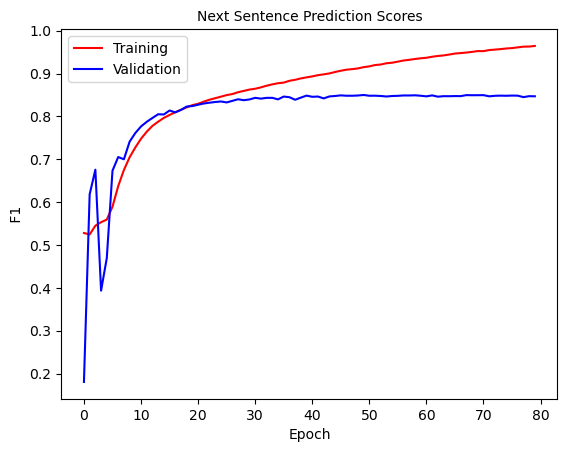

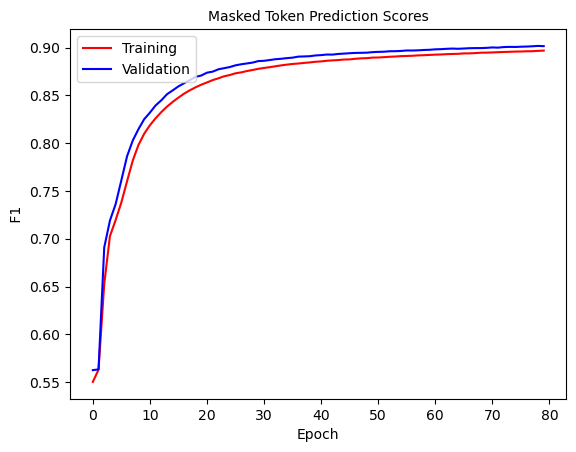

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 80: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.117] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9651163479713915   Masked Token f1 0.8971804373050511     SEQ F1 0.9850097447739997


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8461720115241109    v_masked_token_ F1:  0.9021462599540664  V SEQ F1:  0.9857515036780422


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


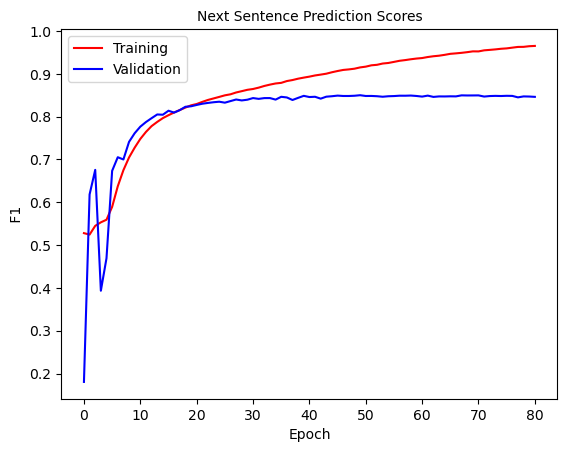

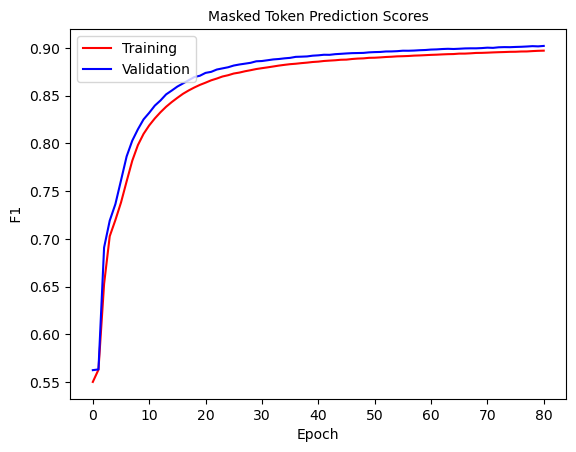

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 81: 100%|██████████| 445/445 [09:13<00:00,  1.24s/it, loss=0.169] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9663003923520975   Masked Token f1 0.8974278049703666     SEQ F1 0.9850543901606007


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.848449522033108    v_masked_token_ F1:  0.902443479619643  V SEQ F1:  0.9857837696393359


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


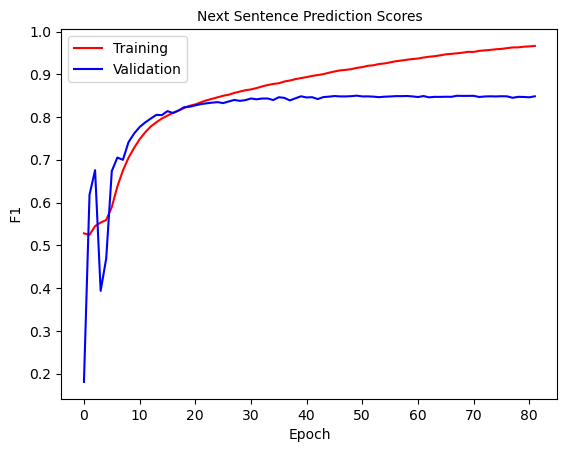

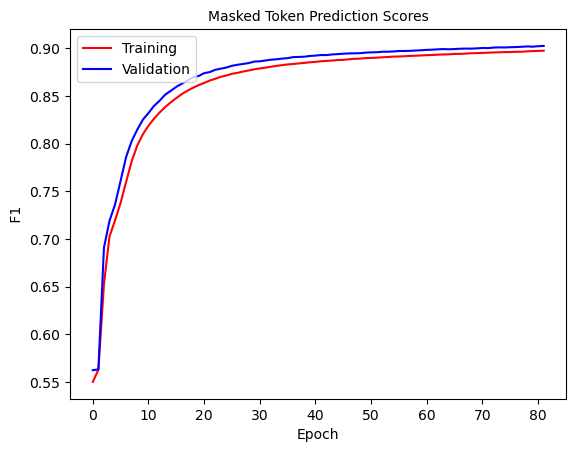

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 82: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.136] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9666299311505326   Masked Token f1 0.8975940762568408     SEQ F1 0.985071716092909


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8471794871794872    v_masked_token_ F1:  0.9028756813191905  V SEQ F1:  0.9858205958543844


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


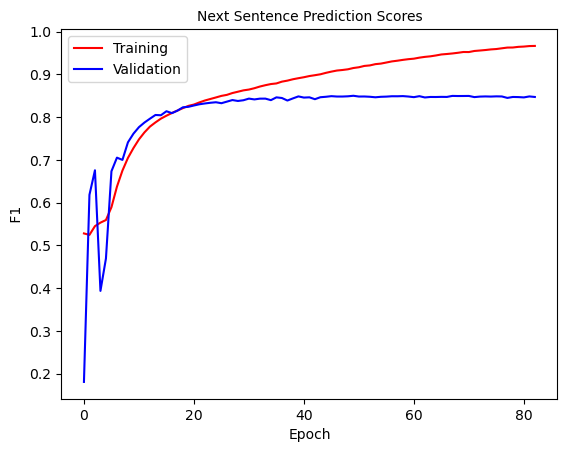

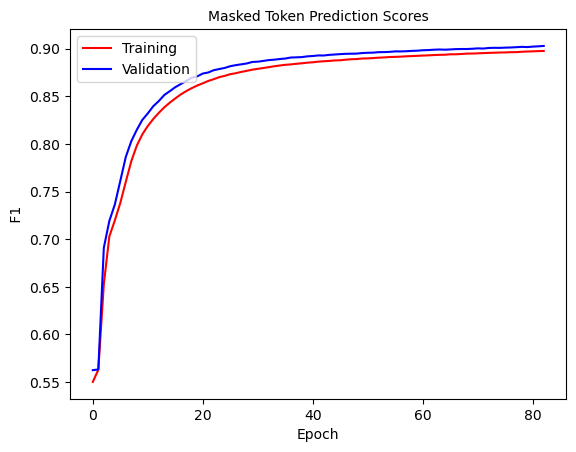

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 83: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.188] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9680641797411954   Masked Token f1 0.8975124120506941     SEQ F1 0.9850727848152223


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8482652202375386    v_masked_token_ F1:  0.902563228029566  V SEQ F1:  0.9858198546873709


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


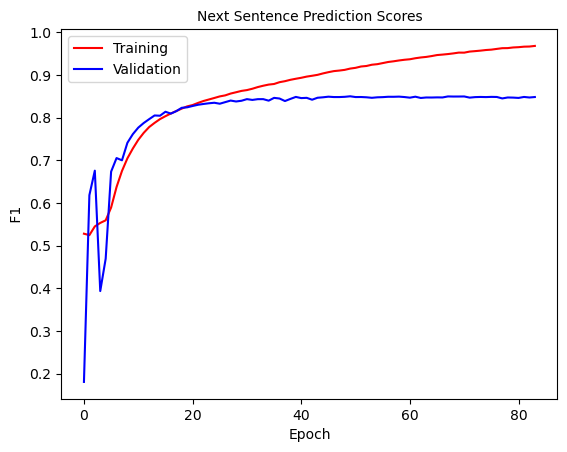

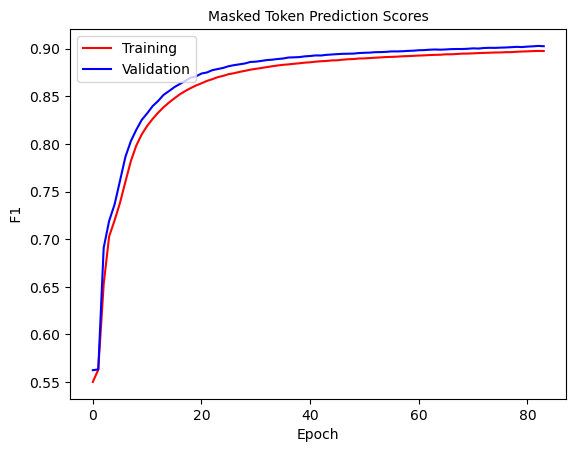

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 84: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.0826]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9691326968493451   Masked Token f1 0.8978033179728779     SEQ F1 0.9851171586535925


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8476631341494936    v_masked_token_ F1:  0.9024440649013363  V SEQ F1:  0.9858305584103304


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


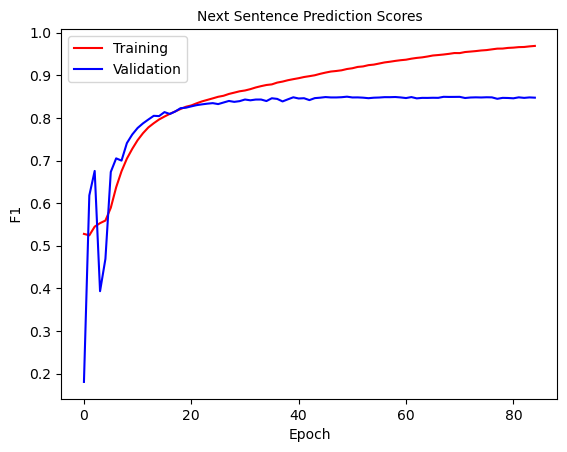

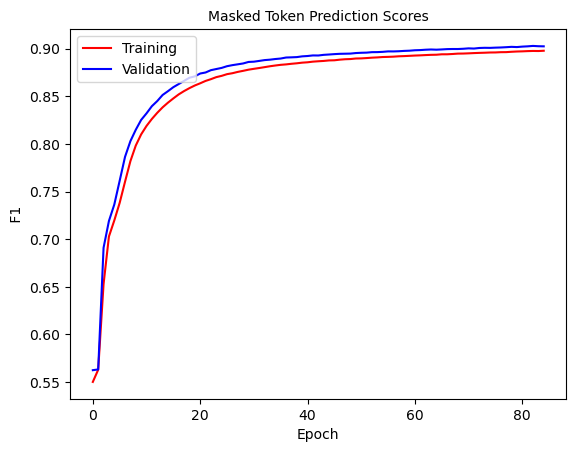

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 85: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.108] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9697156142956026   Masked Token f1 0.8981968125698194     SEQ F1 0.9851782414459014


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8457725534626823    v_masked_token_ F1:  0.9029090047451375  V SEQ F1:  0.9858873539681968


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


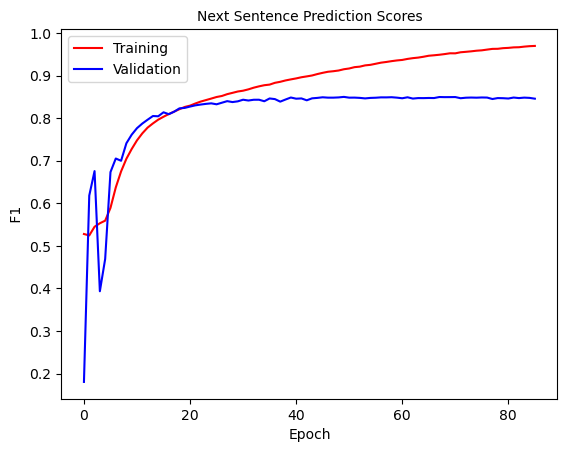

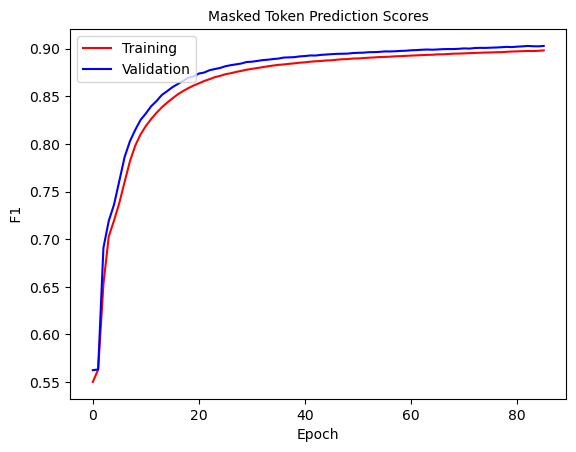

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 86: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.213] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9700481147652555   Masked Token f1 0.8981647017686673     SEQ F1 0.9851823708006024


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8483808109863599    v_masked_token_ F1:  0.9028906057323244  V SEQ F1:  0.9858871883463375


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


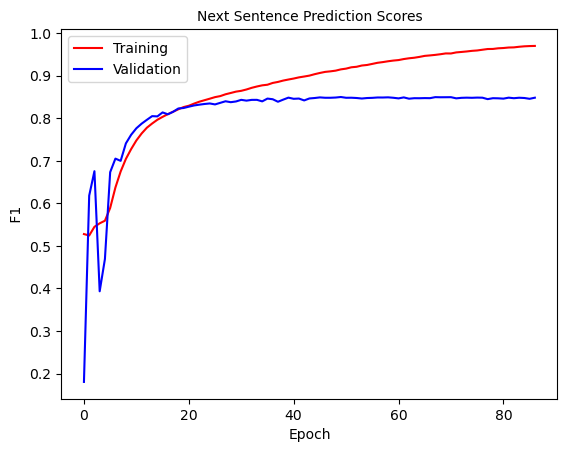

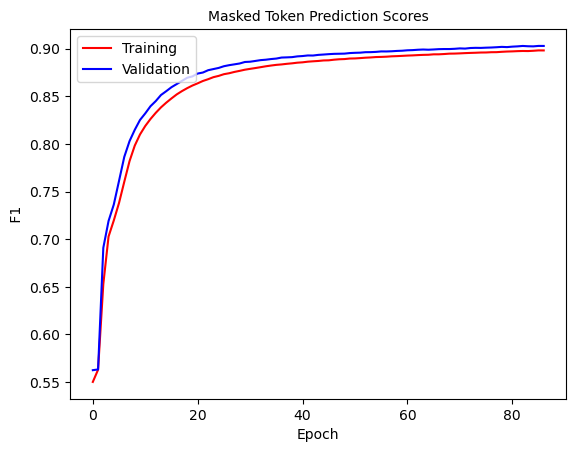

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 87: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.102] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.971978434934932   Masked Token f1 0.8985088619290512     SEQ F1 0.9852359176984085


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8467170468724251    v_masked_token_ F1:  0.9032395949984601  V SEQ F1:  0.9859400554844375


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


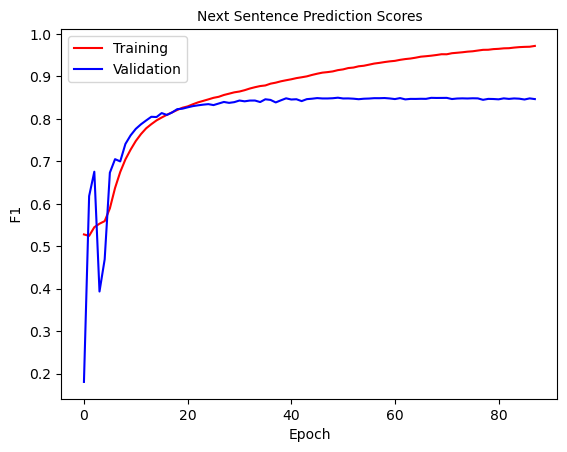

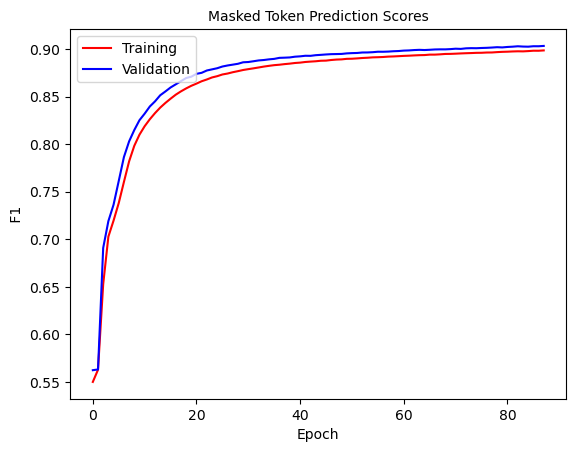

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 88: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.158] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9720768921190313   Masked Token f1 0.8987248673033549     SEQ F1 0.9852679466259916


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8471919491721931    v_masked_token_ F1:  0.9033164095852158  V SEQ F1:  0.985952373516601


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


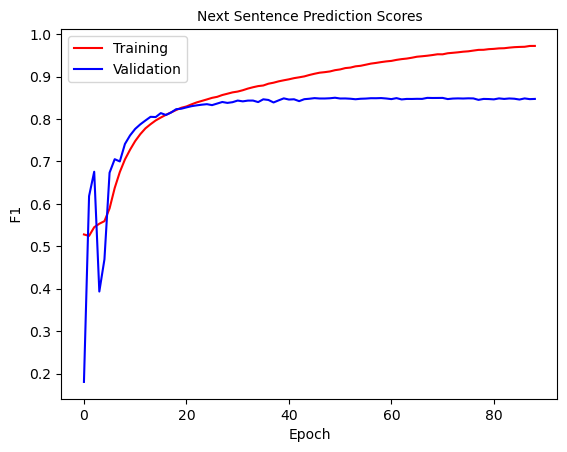

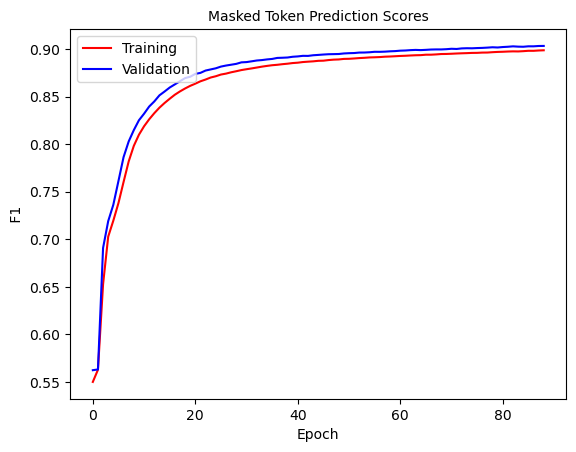

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 89: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.241] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9729854482403555   Masked Token f1 0.8989627809289485     SEQ F1 0.9853115059878322


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8478469796769883    v_masked_token_ F1:  0.9034153378506069  V SEQ F1:  0.9859907315035012


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


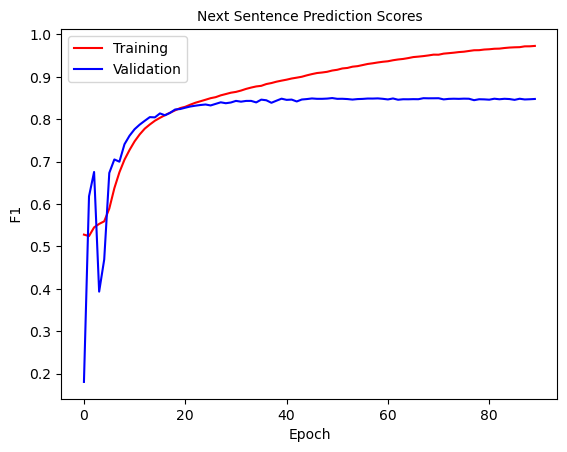

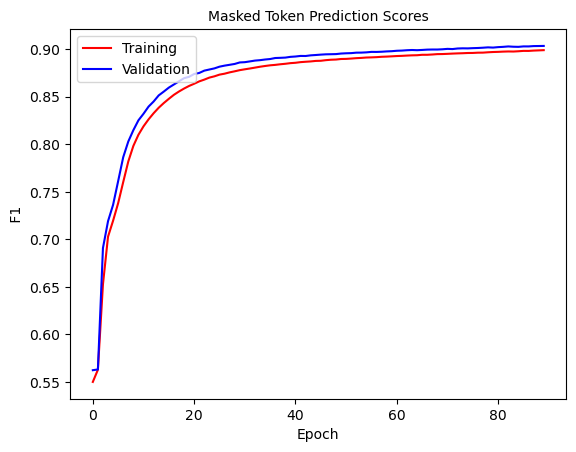

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 90: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.21]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9735252530630838   Masked Token f1 0.8991580479342314     SEQ F1 0.9853411493361884


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8464657895977743    v_masked_token_ F1:  0.9037414844390997  V SEQ F1:  0.9860088700148684


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


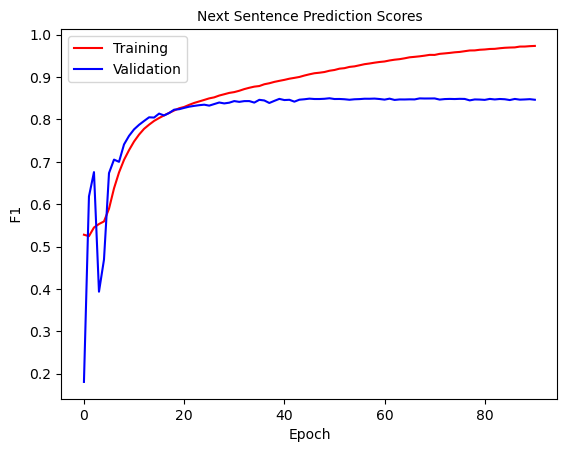

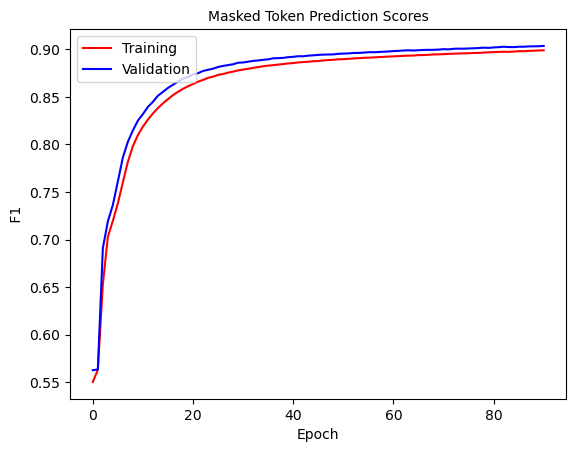

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 91: 100%|██████████| 445/445 [09:12<00:00,  1.24s/it, loss=0.143] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.974744608399546   Masked Token f1 0.8991699057207498     SEQ F1 0.9853470755331519


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8465533855084726    v_masked_token_ F1:  0.9036807470152916  V SEQ F1:  0.9860060207825978


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


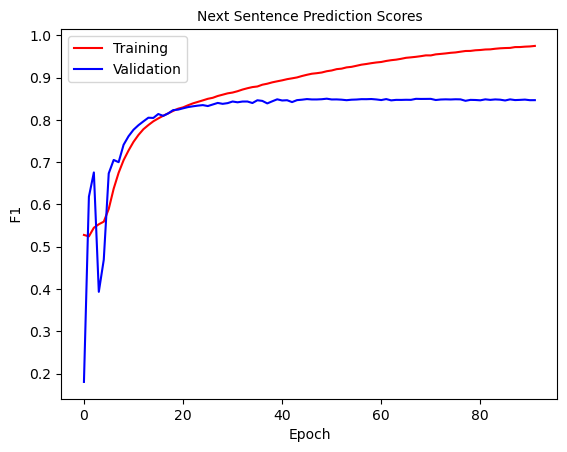

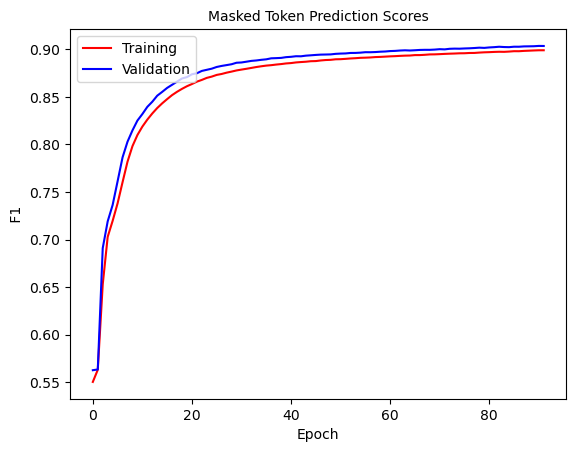

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 92: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.147] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9748504268451297   Masked Token f1 0.8994265305031504     SEQ F1 0.9853916422999957


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8485215366705472    v_masked_token_ F1:  0.903803960183171  V SEQ F1:  0.986016666756872


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


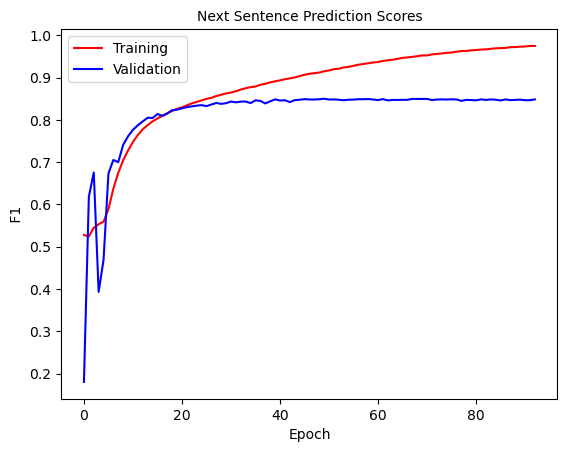

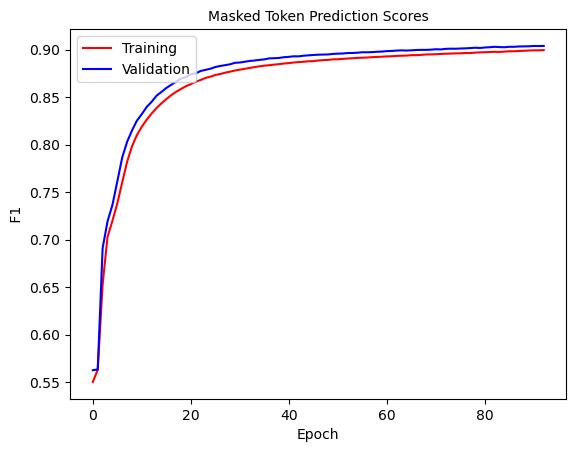

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 93: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.0901]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9753977685935754   Masked Token f1 0.8996848903238377     SEQ F1 0.9854240449327104


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.14it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8469830139063277    v_masked_token_ F1:  0.9044840313497435  V SEQ F1:  0.9860881426837117


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


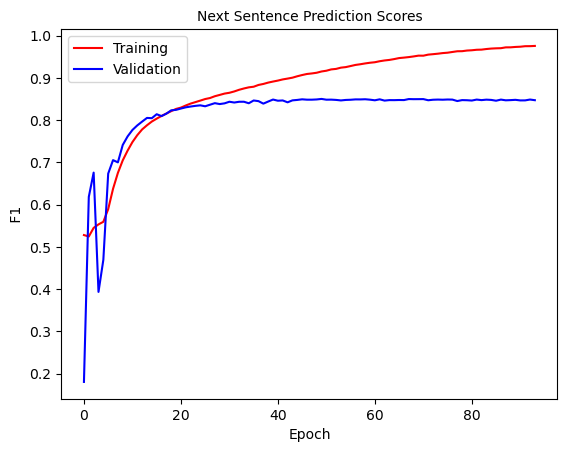

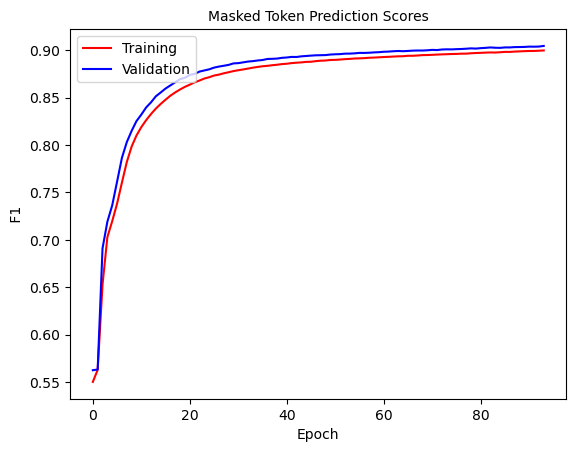

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 94: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.0995]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9763023650346095   Masked Token f1 0.8997561450929228     SEQ F1 0.9854401594626719


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.846262407677471    v_masked_token_ F1:  0.9041362667681552  V SEQ F1:  0.9860958950806012


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


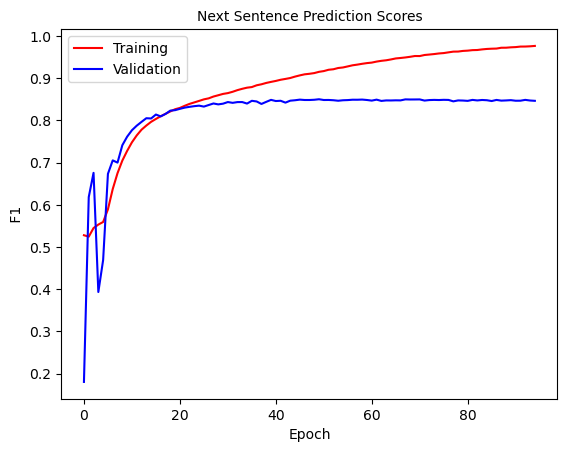

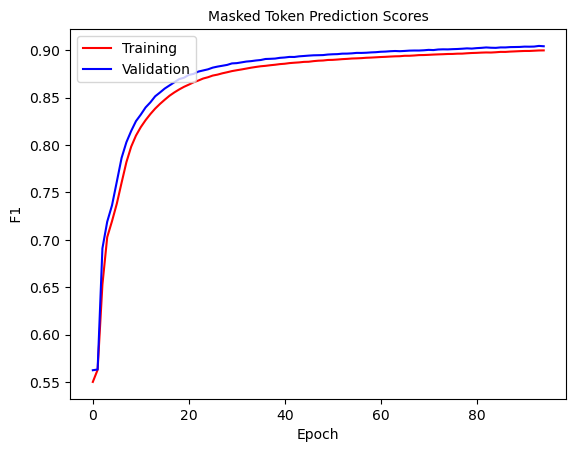

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 95: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.162] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9762069434345942   Masked Token f1 0.8998695587597872     SEQ F1 0.9854638049023943


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8466420870863863    v_masked_token_ F1:  0.9046242703205783  V SEQ F1:  0.9861303218746245


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


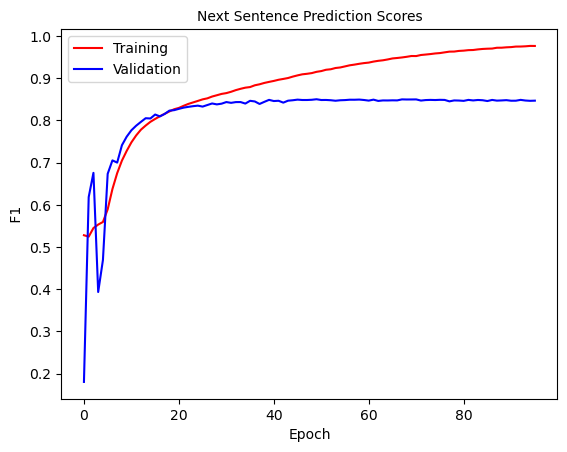

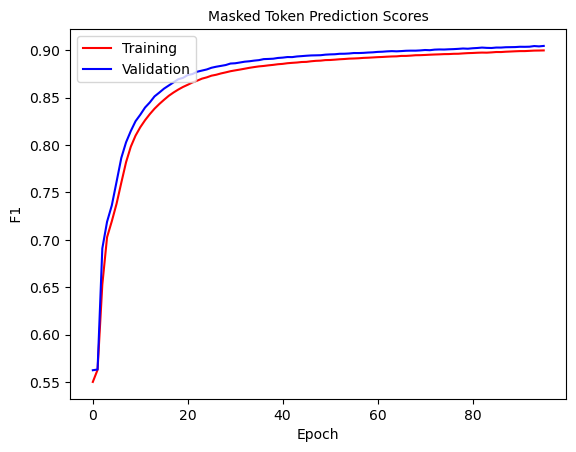

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 96: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.107] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9769712154967114   Masked Token f1 0.9000357038478289     SEQ F1 0.9854952797989709


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8473305548441175    v_masked_token_ F1:  0.904397949407626  V SEQ F1:  0.9861346338708601


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


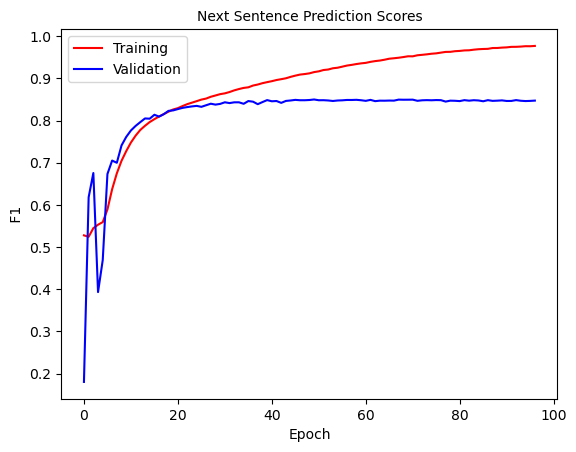

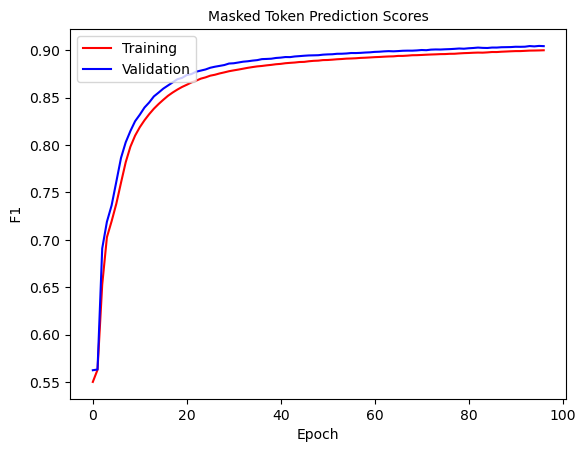

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 97: 100%|██████████| 445/445 [09:10<00:00,  1.24s/it, loss=0.0876]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9781849758103103   Masked Token f1 0.9003793900571366     SEQ F1 0.9855528160222278


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior

Validation:  Instruction F1:  0.847387771350959    v_masked_token_ F1:  0.9049372384431513  V SEQ F1:  0.9862131660684215


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


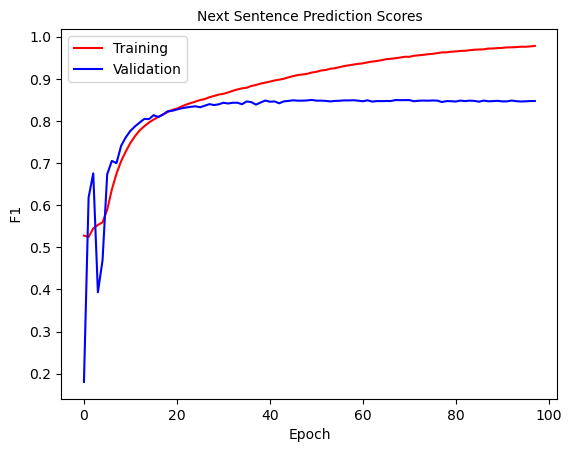

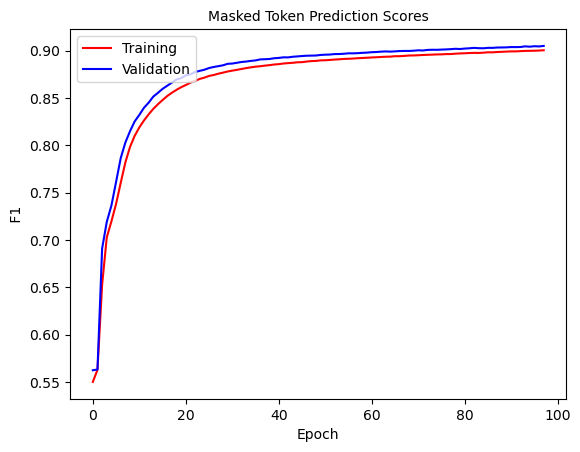

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 98: 100%|██████████| 445/445 [09:09<00:00,  1.24s/it, loss=0.122] 
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Training:   Instruction f1:  0.9787676616062828   Masked Token f1 0.900595386121065     SEQ F1 0.9855818448359851


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:51<00:00,  2.16it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8465497566315004    v_masked_token_ F1:  0.9047271398332104  V SEQ F1:  0.9861988325200581


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


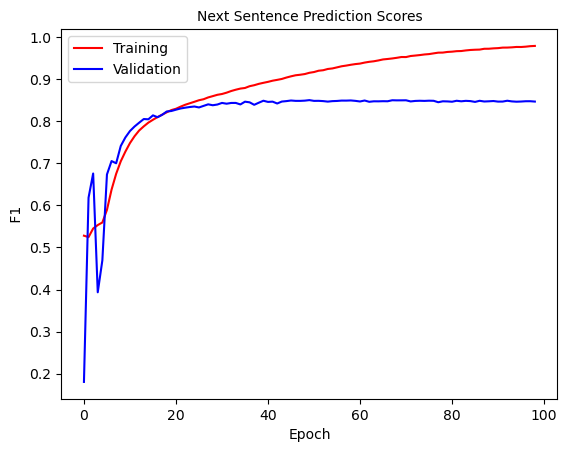

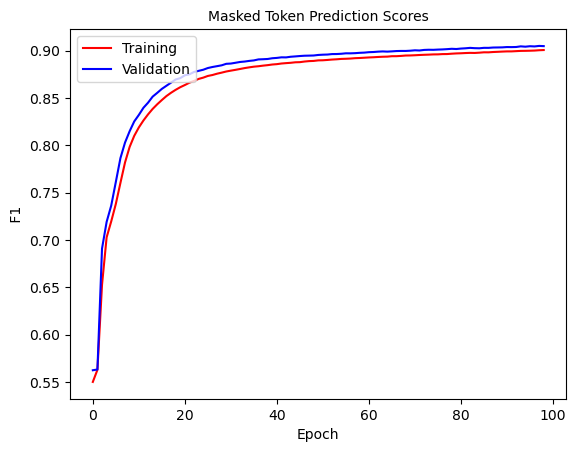

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 99: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.0782]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Training:   Instruction f1:  0.9793047237676743   Masked Token f1 0.900577963729757     SEQ F1 0.9855843542034716


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 112/112 [00:52<00:00,  2.15it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation:  Instruction F1:  0.8455870235656944    v_masked_token_ F1:  0.9048749547256295  V SEQ F1:  0.9862212978564394


/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


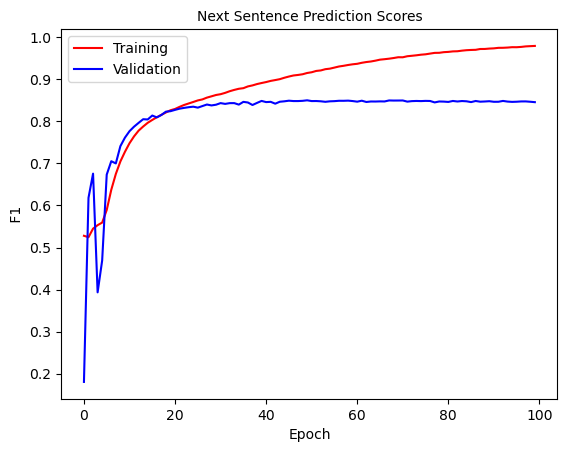

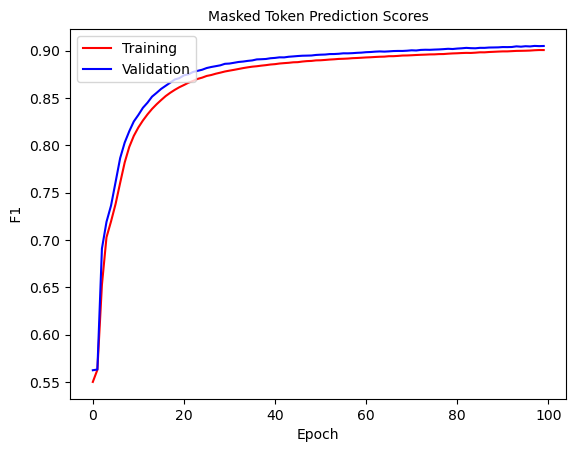

  0%|          | 0/445 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 100: 100%|██████████| 445/445 [09:11<00:00,  1.24s/it, loss=0.12]  
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Training:   Instruction f1:  0.9797003183453131   Masked Token f1 0.9009016241063492     SEQ F1 0.9856340570280235


  0%|          | 0/112 [00:00<?, ?it/s]/tmp/ipykernel_63149/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  4%|▍         | 5/112 [00:02<00:49,  2.17it/s]

In [ ]:
from transformers import AdamW
from tqdm import tqdm  # for our progress bar
from itertools import chain

# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-6)



epochs =1000
counter = 0

global_instruction_metrices = []
global_masked_token_metrices = []

v_global_instruction_metrices = []
v_global_masked_token_metrices = []


for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    train_loop = tqdm(train_loader, leave=True)
    
    
    instruction_predictions_all, instruction_ground_truths_all = None, None
    masked_token_predictions_all, masked_token_ground_truths_all = None, None
    seq_predictions_all, seq_ground_truths_all = None, None
    
    # activate training mode
    model.train()
    for N,batch in enumerate(train_loop):

        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        next_sentence_label = batch['next_sentence_label'].to(device)
        batch_mask_arr = batch ['mask_arr']
        labels = batch['labels'].to(device)

        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        next_sentence_label=next_sentence_label,
                        labels=labels)


        token_prediction = torch.argmax(outputs.prediction_logits, axis=-1)
       


        # batch_masks = selection [BATCH_SIZE*N : (BATCH_SIZE*(N+1))]
        # print('batch_masks old: ',batch_masks)

        # print(batch ['mask_arr'].shape) #torch.flatten(mask_arr[i].nonzero()).tolist()
        batch_masks =   [ torch.flatten(bm.nonzero()).tolist()  for bm in batch_mask_arr]    # torch.flatten(batch ['mask_arr'].nonzero()).tolist()
        # print('batch_masks new: ',batch_masks)
        
        # print("BATCH_SIZE*N : (BATCH_SIZE*(N+1)): ",BATCH_SIZE*N , (BATCH_SIZE*(N+1)) )
        # print("batch_masks:",batch_masks)



        

        masked_token_prediction = [ token[batch_masks[t]].tolist() for t,token in enumerate(token_prediction) ]
        masked_token_prediction = list(chain.from_iterable(masked_token_prediction))
        
        masked_token_ground_truth   = [ token[batch_masks[t]].tolist() for t,token in enumerate(labels) ]
        masked_token_ground_truth = list(chain.from_iterable(masked_token_ground_truth))
        

        # print(token_prediction , token_ground_truth)

        # token_prediction = token_prediction.detach().cpu().numpy().flatten()
        # token_ground_truth = labels.detach().cpu().numpy().flatten()

        # print("token_prediction  : ", token_prediction)
        # print("token_ground_truth: ", token_ground_truth)


        seq_predictions   = token_prediction.detach().cpu().numpy().flatten()
        seq_ground_truths = labels.detach().cpu().numpy().flatten()

        
        instruction_prediction = torch.argmax(outputs.seq_relationship_logits, axis=-1)
        instruction_prediction   = instruction_prediction.detach().cpu().numpy().flatten()
        instruction_ground_truth = next_sentence_label.detach().cpu().numpy().flatten()
        
        if N==0:
            instruction_predictions_all   = instruction_prediction
            instruction_ground_truths_all = instruction_ground_truth
            
            masked_token_predictions_all         = masked_token_prediction
            masked_token_ground_truths_all       = masked_token_ground_truth  


            seq_predictions_all = seq_predictions
            seq_ground_truths_all = seq_ground_truths
            
        else:
            instruction_predictions_all   = np.concatenate((instruction_predictions_all, instruction_prediction))
            instruction_ground_truths_all = np.concatenate((instruction_ground_truths_all, instruction_ground_truth))
            
            masked_token_predictions_all   = np.concatenate((masked_token_predictions_all, masked_token_prediction))
            masked_token_ground_truths_all = np.concatenate((masked_token_ground_truths_all, masked_token_ground_truth))

            seq_predictions_all = np.concatenate((seq_predictions_all, seq_predictions))
            seq_ground_truths_all = np.concatenate((seq_ground_truths_all, seq_ground_truths))
            

        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())
    
    
    instruction_accuracy = (accuracy_score(instruction_ground_truths_all,instruction_predictions_all))
    instruction_precision, instruction_recall, instruction_f1, _ = precision_recall_fscore_support(instruction_ground_truths_all,instruction_predictions_all, average='binary')
    
    masked_token_accuracy = (accuracy_score(masked_token_ground_truths_all, masked_token_predictions_all))
    masked_token_precision, masked_token_recall, masked_token_f1, _ = precision_recall_fscore_support(masked_token_ground_truths_all,masked_token_predictions_all,average='weighted')

    seq_precision, seq_recall, seq_f1, _ = precision_recall_fscore_support(seq_ground_truths_all,seq_predictions_all,average='weighted')
    
    print("Training: ",  ' Instruction f1: ', instruction_f1 , '  Masked Token f1',masked_token_f1 , "    SEQ F1",seq_f1)
    global_instruction_metrices.append(instruction_f1)
    global_masked_token_metrices.append( masked_token_f1) 

    ###########################################
    ###############  EVAL Validation  #########
    ###########################################
    with torch.no_grad():
        model.eval()
#         v_predictions_all, v_ground_truths_all = None, None
        
        v_instruction_predictions_all, v_instruction_ground_truths_all = None, None
        v_masked_token_predictions_all, v_masked_token_ground_truths_all = None, None
        v_seq_predictions_all, v_seq_ground_truths_all = None, None
    
    
        validation_loop = tqdm(validation_loader, leave=True)
        for N,v_batch in enumerate(validation_loop):
            
            
            
            v_input_ids = v_batch['input_ids'].to(device)
            v_token_type_ids = v_batch['token_type_ids'].to(device)
            v_attention_mask = v_batch['attention_mask'].to(device)
            v_next_sentence_label = v_batch['next_sentence_label'].to(device)
            v_mask_arr = v_batch ['mask_arr']
            v_labels = v_batch['labels'].to(device)
            # process
            v_outputs = model(v_input_ids, attention_mask=v_attention_mask,
                            token_type_ids=v_token_type_ids,
                            next_sentence_label=v_next_sentence_label,
                            labels=v_labels)
        
            v_token_prediction = torch.argmax(v_outputs.prediction_logits, axis=-1)

                    

            v_batch_masks =   [ torch.flatten(bm.nonzero()).tolist()  for bm in v_mask_arr]
            
            v_masked_token_prediction = [ token[v_batch_masks[t]].tolist() for t,token in enumerate(v_token_prediction) ]
            v_masked_token_prediction = list(chain.from_iterable(v_masked_token_prediction))
            
            v_masked_token_ground_truth   = [ token[v_batch_masks[t]].tolist() for t,token in enumerate(v_labels) ]
            v_masked_token_ground_truth = list(chain.from_iterable(v_masked_token_ground_truth))
    
            
            

            v_seq_prediction = v_token_prediction.detach().cpu().numpy().flatten()
            v_seq_ground_truth = v_labels.detach().cpu().numpy().flatten()


            

            # token_prediction = [ token[batch_masks[t]].tolist() for t,token in enumerate(token_prediction) ]
            # token_prediction = list(chain.from_iterable(token_prediction))
            
            # token_ground_truth   = [ token[batch_masks[t]].tolist() for t,token in enumerate(labels) ]
            # token_ground_truth = list(chain.from_iterable(token_ground_truth))

            
            v_instruction_prediction = torch.argmax(v_outputs.seq_relationship_logits, axis=-1)
            v_instruction_prediction   = v_instruction_prediction.detach().cpu().numpy().flatten()
            v_instruction_ground_truth = v_next_sentence_label.detach().cpu().numpy().flatten()



        

            if N==0:
                v_instruction_predictions_all   = v_instruction_prediction
                v_instruction_ground_truths_all = v_instruction_ground_truth

                v_masked_token_predictions_all   = v_masked_token_prediction
                v_masked_token_ground_truths_all = v_masked_token_ground_truth
                
                v_seq_predictions_all= v_seq_prediction
                v_seq_ground_truths_all = v_seq_ground_truth

        

            else:
                v_instruction_predictions_all   = np.concatenate((v_instruction_predictions_all, v_instruction_prediction))
                v_instruction_ground_truths_all = np.concatenate((v_instruction_ground_truths_all, v_instruction_ground_truth))

                v_masked_token_predictions_all   = np.concatenate((v_masked_token_predictions_all, v_masked_token_prediction ))
                v_masked_token_ground_truths_all = np.concatenate((v_masked_token_ground_truths_all, v_masked_token_ground_truth ))
                
                v_seq_predictions_all =np.concatenate((v_seq_predictions_all, v_seq_prediction ))
                v_seq_ground_truths_all =np.concatenate((v_seq_ground_truths_all, v_seq_ground_truth ))
                

            

        v_instruction_accuracy = (accuracy_score(v_instruction_ground_truths_all,v_instruction_predictions_all))
        v_instruction_precision, v_instruction_recall, v_instruction_f1, _ = precision_recall_fscore_support(v_instruction_ground_truths_all,v_instruction_predictions_all, average='binary')


        v_masked_token_accuracy = (accuracy_score(v_masked_token_ground_truths_all, v_masked_token_predictions_all))
        v_masked_token_precision, v_masked_token_recall, v_masked_token_f1, _ = precision_recall_fscore_support(v_masked_token_ground_truths_all,v_masked_token_predictions_all,average='weighted')


        v_seq_accuracy = (accuracy_score(v_seq_predictions_all, v_seq_ground_truths_all))
        v_seq_precision, v_seq_recall, v_seq_f1, _ = precision_recall_fscore_support(v_seq_ground_truths_all,v_seq_predictions_all,average='weighted')

        print("Validation: ", "Instruction F1: ", v_instruction_f1,  "   v_masked_token_ F1: ",v_masked_token_f1 ," V SEQ F1: ", v_seq_f1)
        
        v_global_instruction_metrices.append(v_instruction_f1)
        v_global_masked_token_metrices.append(v_masked_token_f1) 

    
    plot_graph(global_instruction_metrices, v_global_instruction_metrices, 'Next Sentence Prediction Scores')
    plot_graph(global_masked_token_metrices, v_global_masked_token_metrices, 'Masked Token Prediction Scores')
    # model.save_pretrained("./../models/MLM_NSP_512_redo.ckpt")

In [ ]:
# Save the trained model weights


In [ ]:
a=[0,1,2,3,4,5]
a[0:3]